# About this notebook

- PyTorch se_resnext50 classification starter code  
- 4 folds 

If this notebook is helpful, feel free to upvote :)  

# Config

In [6]:
class CFG:
    debug=True
    height=256
    width=256
    lr=1e-4
    batch_size=16
    epochs=8
    seed=42
    target_size=6 #1
    target_col='isup_grade'
    n_fold=4

# Library

In [7]:
import os
import numpy as np 
import pandas as pd 

In [8]:
os.listdir('./panda-resized-train-data-512x512/')

['train.csv',
 'sample_submission.csv',
 'train_images',
 'train_label_masks',
 'test.csv']

# Data Loading

In [9]:
train = pd.read_csv('./panda-resized-train-data-512x512/train.csv')
test = pd.read_csv('./panda-resized-train-data-512x512/test.csv')
sample = pd.read_csv('./panda-resized-train-data-512x512/sample_submission.csv')

In [10]:
train.head()

,image_id,data_provider,isup_grade,gleason_score
0,0005f7aaab2800f6170c399693a96917,karolinska,0,0+0
1,000920ad0b612851f8e01bcc880d9b3d,karolinska,0,0+0
2,0018ae58b01bdadc8e347995b69f99aa,radboud,4,4+4
3,001c62abd11fa4b57bf7a6c603a11bb9,karolinska,4,4+4
4,001d865e65ef5d2579c190a0e0350d8f,karolinska,0,0+0


In [11]:
test.head()

,image_id,data_provider
0,005700be7e06878e6605e7a5a39de1b2,radboud
1,005c6e8877caf724c600fdce5d417d40,karolinska
2,0104f76634ff89bfff1ef0804a95c380,radboud


In [12]:
sample.head()

,image_id,isup_grade
0,005700be7e06878e6605e7a5a39de1b2,0
1,005c6e8877caf724c600fdce5d417d40,0
2,0104f76634ff89bfff1ef0804a95c380,0


In [13]:
''.

SyntaxError: invalid syntax (<ipython-input-13-92eeab8ba50e>, line 1)

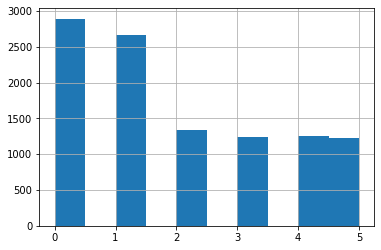

In [14]:
train['isup_grade'].hist()

# Library

In [15]:
# ====================================================
# Library
# ====================================================

import sys

import gc
import os
import random
import time
from contextlib import contextmanager
from pathlib import Path
from collections import defaultdict, Counter

import skimage.io
import cv2
from PIL import Image
import numpy as np
import pandas as pd
import scipy as sp

import sklearn.metrics
from sklearn.metrics import accuracy_score
from sklearn.model_selection import StratifiedKFold

from functools import partial
from tqdm import tqdm

import torch
import torch.nn as nn
from torch.optim import Adam, SGD
from torch.optim.lr_scheduler import CosineAnnealingLR, ReduceLROnPlateau
from torch.utils.data import DataLoader, Dataset
import torchvision.models as models

from albumentations import Compose, Normalize, HorizontalFlip, VerticalFlip
from albumentations.pytorch import ToTensorV2

import warnings 
warnings.filterwarnings('ignore')


device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda')

# Utils

In [16]:
# ====================================================
# Utils
# ====================================================

@contextmanager
def timer(name):
    t0 = time.time()
    LOGGER.info(f'[{name}] start')
    yield
    LOGGER.info(f'[{name}] done in {time.time() - t0:.0f} s.')

    
def init_logger(log_file='train.log'):
    from logging import getLogger, DEBUG, FileHandler,  Formatter,  StreamHandler
    
    log_format = '%(asctime)s %(levelname)s %(message)s'
    
    stream_handler = StreamHandler()
    stream_handler.setLevel(DEBUG)
    stream_handler.setFormatter(Formatter(log_format))
    
    file_handler = FileHandler(log_file)
    file_handler.setFormatter(Formatter(log_format))
    
    logger = getLogger('PANDA')
    logger.setLevel(DEBUG)
    logger.addHandler(stream_handler)
    logger.addHandler(file_handler)
    
    return logger

LOG_FILE = 'train.log'
LOGGER = init_logger(LOG_FILE)


def seed_torch(seed=42):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True

seed_torch(seed=42)

# Dataset

In [17]:
class TrainDataset(Dataset):
    def __init__(self, df, labels, transform=None):
        self.df = df
        self.labels = labels
        self.transform = transform
        
    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        file_name = self.df['image_id'].values[idx]
        file_path = f'./panda-resized-train-data-512x512/train_images/train_images/{file_name}.png'
        image = skimage.io.MultiImage(file_path)
        image = cv2.resize(image[-1], (CFG.height, CFG.width))
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        
        if self.transform:
            augmented = self.transform(image=image)
            image = augmented['image']
            
        label = self.labels[idx]
        
        return image, label
    

class TestDataset(Dataset):
    def __init__(self, df, dir_name, transform=None):
        self.df = df
        self.dir_name = dir_name
        self.transform = transform
        
    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        file_name = self.df['image_id'].values[idx]
        file_path = f'../input/prostate-cancer-grade-assessment/test_images/{self.dir_name}/{file_name}.tiff'
        image = skimage.io.MultiImage(file_path)
        image = cv2.resize(image[-1], (CFG.height, CFG.width))
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        
        if self.transform:
            augmented = self.transform(image=image)
            image = augmented['image']
        
        return image

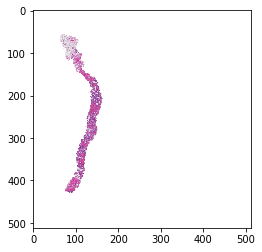

CPU times: user 120 ms, sys: 4.3 ms, total: 124 ms
Wall time: 137 ms


In [18]:
%%time

from matplotlib import pyplot

image = skimage.io.MultiImage('./panda-resized-train-data-512x512/train_images/train_images/0005f7aaab2800f6170c399693a96917.png')
image = cv2.cvtColor(image[-1], cv2.COLOR_BGR2RGB)
pyplot.imshow(image)
pyplot.show()  

In [19]:
del image; gc.collect()

2382

# Transforms

In [20]:
def get_transforms(*, data):
    
    assert data in ('train', 'valid')
    
    if data == 'train':
        return Compose([
            HorizontalFlip(p=0.5),
            VerticalFlip(p=0.5),
            Normalize(
                mean=[0.485, 0.456, 0.406],
                std=[0.229, 0.224, 0.225],
            ),
            ToTensorV2(),
        ])
    
    elif data == 'valid':
        return Compose([
            Normalize(
                mean=[0.485, 0.456, 0.406],
                std=[0.229, 0.224, 0.225],
            ),
            ToTensorV2(),
        ])

# train valid split

In [21]:
if CFG.debug:
    folds = train.sample(n=20, random_state=CFG.seed).reset_index(drop=True).copy()
else:
    folds = train.copy()

In [22]:
train_labels = folds[CFG.target_col].values
kf = StratifiedKFold(n_splits=CFG.n_fold, shuffle=True, random_state=CFG.seed)
for fold, (train_index, val_index) in enumerate(kf.split(folds.values, train_labels)):
    folds.loc[val_index, 'fold'] = int(fold)
folds['fold'] = folds['fold'].astype(int)
folds.to_csv('folds.csv', index=None)
folds.head()

,image_id,data_provider,isup_grade,gleason_score,fold
0,e8baa3bb9dcfb9cef5ca599d62bb8046,karolinska,4,4+4,1
1,9b2948ff81b64677a1a152a1532c1a50,karolinska,2,3+4,1
2,5b003d43ec0ce5979062442486f84cf7,radboud,4,5+3,0
3,375b2c9501320b35ceb638a3274812aa,radboud,1,3+3,0
4,e4e49a91640feea58d109aff11df4197,karolinska,1,3+3,3


# Model

In [63]:
# https://github.com/Cadene/pretrained-models.pytorch/blob/master/pretrainedmodels/models/senet.py

from collections import OrderedDict
import math


class SEModule(nn.Module):

    def __init__(self, channels, reduction):
        super(SEModule, self).__init__()
        self.avg_pool = nn.AdaptiveAvgPool2d(1)
        self.fc1 = nn.Conv2d(channels, channels // reduction, kernel_size=1,
                             padding=0)
        self.relu = nn.ReLU(inplace=True)
        self.fc2 = nn.Conv2d(channels // reduction, channels, kernel_size=1,
                             padding=0)
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        module_input = x
        x = self.avg_pool(x)
        x = self.fc1(x)
        x = self.relu(x)
        x = self.fc2(x)
        x = self.sigmoid(x)
        return module_input * x


class Bottleneck(nn.Module):
    """
    Base class for bottlenecks that implements `forward()` method.
    """
    def forward(self, x):
        residual = x

        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)

        out = self.conv2(out)
        out = self.bn2(out)
        out = self.relu(out)

        out = self.conv3(out)
        out = self.bn3(out)

        if self.downsample is not None:
            residual = self.downsample(x)

        out = self.se_module(out) + residual
        out = self.relu(out)

        return out


class SEBottleneck(Bottleneck):
    """
    Bottleneck for SENet154.
    """
    expansion = 4

    def __init__(self, inplanes, planes, groups, reduction, stride=1,
                 downsample=None):
        super(SEBottleneck, self).__init__()
        self.conv1 = nn.Conv2d(inplanes, planes * 2, kernel_size=1, bias=False)
        self.bn1 = nn.BatchNorm2d(planes * 2)
        self.conv2 = nn.Conv2d(planes * 2, planes * 4, kernel_size=3,
                               stride=stride, padding=1, groups=groups,
                               bias=False)
        self.bn2 = nn.BatchNorm2d(planes * 4)
        self.conv3 = nn.Conv2d(planes * 4, planes * 4, kernel_size=1,
                               bias=False)
        self.bn3 = nn.BatchNorm2d(planes * 4)
        self.relu = nn.ReLU(inplace=True)
        self.se_module = SEModule(planes * 4, reduction=reduction)
        self.downsample = downsample
        self.stride = stride


class SEResNetBottleneck(Bottleneck):
    """
    ResNet bottleneck with a Squeeze-and-Excitation module. It follows Caffe
    implementation and uses `stride=stride` in `conv1` and not in `conv2`
    (the latter is used in the torchvision implementation of ResNet).
    """
    expansion = 4

    def __init__(self, inplanes, planes, groups, reduction, stride=1,
                 downsample=None):
        super(SEResNetBottleneck, self).__init__()
        self.conv1 = nn.Conv2d(inplanes, planes, kernel_size=1, bias=False,
                               stride=stride)
        self.bn1 = nn.BatchNorm2d(planes)
        self.conv2 = nn.Conv2d(planes, planes, kernel_size=3, padding=1,
                               groups=groups, bias=False)
        self.bn2 = nn.BatchNorm2d(planes)
        self.conv3 = nn.Conv2d(planes, planes * 4, kernel_size=1, bias=False)
        self.bn3 = nn.BatchNorm2d(planes * 4)
        self.relu = nn.ReLU(inplace=True)
        self.se_module = SEModule(planes * 4, reduction=reduction)
        self.downsample = downsample
        self.stride = stride


class SEResNeXtBottleneck(Bottleneck):
    """
    ResNeXt bottleneck type C with a Squeeze-and-Excitation module.
    """
    expansion = 4

    def __init__(self, inplanes, planes, groups, reduction, stride=1,
                 downsample=None, base_width=4):
        super(SEResNeXtBottleneck, self).__init__()
        width = math.floor(planes * (base_width / 64)) * groups
        self.conv1 = nn.Conv2d(inplanes, width, kernel_size=1, bias=False,
                               stride=1)
        self.bn1 = nn.BatchNorm2d(width)
        self.conv2 = nn.Conv2d(width, width, kernel_size=3, stride=stride,
                               padding=1, groups=groups, bias=False)
        self.bn2 = nn.BatchNorm2d(width)
        self.conv3 = nn.Conv2d(width, planes * 4, kernel_size=1, bias=False)
        self.bn3 = nn.BatchNorm2d(planes * 4)
        self.relu = nn.ReLU(inplace=True)
        self.se_module = SEModule(planes * 4, reduction=reduction)
        self.downsample = downsample
        self.stride = stride


class SENet(nn.Module):

    def __init__(self, block, layers, groups, reduction, dropout_p=0.2,
                 inplanes=128, input_3x3=True, downsample_kernel_size=3,
                 downsample_padding=1, num_classes=1000):
        super(SENet, self).__init__()
        self.inplanes = inplanes
        if input_3x3:
            layer0_modules = [
                ('conv1', nn.Conv2d(3, 64, 3, stride=2, padding=1,
                                    bias=False)),
                ('bn1', nn.BatchNorm2d(64)),
                ('relu1', nn.ReLU(inplace=True)),
                ('conv2', nn.Conv2d(64, 64, 3, stride=1, padding=1,
                                    bias=False)),
                ('bn2', nn.BatchNorm2d(64)),
                ('relu2', nn.ReLU(inplace=True)),
                ('conv3', nn.Conv2d(64, inplanes, 3, stride=1, padding=1,
                                    bias=False)),
                ('bn3', nn.BatchNorm2d(inplanes)),
                ('relu3', nn.ReLU(inplace=True)),
            ]
        else:
            layer0_modules = [
                ('conv1', nn.Conv2d(3, inplanes, kernel_size=7, stride=2,
                                    padding=3, bias=False)),
                ('bn1', nn.BatchNorm2d(inplanes)),
                ('relu1', nn.ReLU(inplace=True)),
            ]
        # To preserve compatibility with Caffe weights `ceil_mode=True`
        # is used instead of `padding=1`.
        layer0_modules.append(('pool', nn.MaxPool2d(3, stride=2,
                                                    ceil_mode=True)))
        self.layer0 = nn.Sequential(OrderedDict(layer0_modules))
        self.layer1 = self._make_layer(
            block,
            planes=64,
            blocks=layers[0],
            groups=groups,
            reduction=reduction,
            downsample_kernel_size=1,
            downsample_padding=0
        )
        self.layer2 = self._make_layer(
            block,
            planes=128,
            blocks=layers[1],
            stride=2,
            groups=groups,
            reduction=reduction,
            downsample_kernel_size=downsample_kernel_size,
            downsample_padding=downsample_padding
        )
        self.layer3 = self._make_layer(
            block,
            planes=256,
            blocks=layers[2],
            stride=2,
            groups=groups,
            reduction=reduction,
            downsample_kernel_size=downsample_kernel_size,
            downsample_padding=downsample_padding
        )
        self.layer4 = self._make_layer(
            block,
            planes=512,
            blocks=layers[3],
            stride=2,
            groups=groups,
            reduction=reduction,
            downsample_kernel_size=downsample_kernel_size,
            downsample_padding=downsample_padding
        )
        self.avg_pool = nn.AvgPool2d(7, stride=1)
        self.dropout = nn.Dropout(dropout_p) if dropout_p is not None else None
        self.last_linear = nn.Linear(512 * block.expansion, num_classes)

    def _make_layer(self, block, planes, blocks, groups, reduction, stride=1,
                    downsample_kernel_size=1, downsample_padding=0):
        downsample = None
        if stride != 1 or self.inplanes != planes * block.expansion:
            downsample = nn.Sequential(
                nn.Conv2d(self.inplanes, planes * block.expansion,
                          kernel_size=downsample_kernel_size, stride=stride,
                          padding=downsample_padding, bias=False),
                nn.BatchNorm2d(planes * block.expansion),
            )

        layers = []
        layers.append(block(self.inplanes, planes, groups, reduction, stride,
                            downsample))
        self.inplanes = planes * block.expansion
        for i in range(1, blocks):
            layers.append(block(self.inplanes, planes, groups, reduction))

        return nn.Sequential(*layers)

    def features(self, x):
        x = self.layer0(x)
        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.layer4(x)
        return x

    def logits(self, x):
        x = self.avg_pool(x)
        if self.dropout is not None:
            x = self.dropout(x)
        x = x.view(x.size(0), -1)
        x = self.last_linear(x)
        return x

    def forward(self, x):
        x = self.features(x)
        x = self.logits(x)
        return x


def initialize_pretrained_model(model, num_classes, settings):
    assert num_classes == settings['num_classes'], \
        'num_classes should be {}, but is {}'.format(
            settings['num_classes'], num_classes)
    model.load_state_dict(model_zoo.load_url(settings['url']))
    model.input_space = settings['input_space']
    model.input_size = settings['input_size']
    model.input_range = settings['input_range']
    model.mean = settings['mean']
    model.std = settings['std']


def se_resnext50_32x4d(num_classes=1000):
    model = SENet(SEResNeXtBottleneck, [3, 4, 6, 3], groups=32, reduction=16,
                  dropout_p=None, inplanes=64, input_3x3=False,
                  downsample_kernel_size=1, downsample_padding=0,
                  num_classes=num_classes)
    return model


def se_resnext101_32x4d(num_classes=1000, pretrained='imagenet'):
    model = SENet(SEResNeXtBottleneck, [3, 4, 23, 3], groups=32, reduction=16,
                  dropout_p=None, inplanes=64, input_3x3=False,
                  downsample_kernel_size=1, downsample_padding=0,
                  num_classes=num_classes)
    if pretrained is not None:
        settings = pretrained_settings['se_resnext101_32x4d'][pretrained]
        initialize_pretrained_model(model, num_classes, settings)
    return model

In [56]:
pretrained_path = {'se_resnext50_32x4d': './pretrained_models/se_resnext50_32x4d-a260b3a4.pth'}

class CustomSEResNeXt(nn.Module):

    def __init__(self, model_name='se_resnext50_32x4d'):
        assert model_name in ('se_resnext50_32x4d')
        super().__init__()
        
        self.model = se_resnext50_32x4d(pretrained=None)
        weights_path = pretrained_path[model_name]
        checkpoint = torch.load(weights_path, map_location=lambda storage, loc: storage)
        self.model.load_state_dict(checkpoint['state_dict'])
        #self.model.load_state_dict(torch.load(weights_path)['state_dict'])
        self.model.avg_pool = nn.AdaptiveAvgPool2d(1)
        self.model.last_linear = nn.Linear(self.model.last_linear.in_features, CFG.target_size)
        
    def forward(self, x):
        x = self.model(x)
        return x

In [33]:
weights = torch.load(pretrained_path['se_resnext50_32x4d'])['state_dict']

In [95]:
import ntpath
#from models.seresnext import *
def convert_model(model, full_checkpoint_path, output_path):
    checkpoint = torch.load(full_checkpoint_path, map_location=lambda storage, loc: storage)

    sanitized_dict = {}
    for k, v in checkpoint["state_dict"].items():        
        sanitized_dict[k.replace("model.", "")] = v

    sample = torch.rand(1, 3, 256, 256, dtype=torch.float32)
    model.load_state_dict(sanitized_dict)
    scripted_model = torch.jit.trace(model, sample)
    filename = ntpath.basename(full_checkpoint_path).split('.')[0]
    os.makedirs(output_path, exist_ok=True)
    scripted_model.save(f"{output_path}/{filename}.pth")

In [96]:
class CustomSEResNeXt(nn.Module):

    def __init__(self):
        super().__init__()

        self.model = se_resnext50_32x4d()
        self.model.avg_pool = nn.AdaptiveAvgPool2d(1)
        self.model.last_linear = nn.Linear(self.model.last_linear.in_features, 6)

    def forward(self, x):
        x = self.model(x)
        return x

In [97]:
model = CustomSEResNeXt()
torch.jit.trace(model, sample)

RuntimeError: Type 'Tuple[str, str]' cannot be traced. Only Tensors and (possibly nested) Lists, Dicts, and Tuples of Tensors can be traced (toTraceableIValue at /opt/conda/conda-bld/pytorch_1573049310284/work/torch/csrc/jit/pybind_utils.h:298)
frame #0: c10::Error::Error(c10::SourceLocation, std::string const&) + 0x47 (0x7f7dde940687 in /home/dex/anaconda3/lib/python3.7/site-packages/torch/lib/libc10.so)
frame #1: <unknown function> + 0x4fae72 (0x7f7e0e897e72 in /home/dex/anaconda3/lib/python3.7/site-packages/torch/lib/libtorch_python.so)
frame #2: <unknown function> + 0x5ba3b0 (0x7f7e0e9573b0 in /home/dex/anaconda3/lib/python3.7/site-packages/torch/lib/libtorch_python.so)
frame #3: <unknown function> + 0x58bc8c (0x7f7e0e928c8c in /home/dex/anaconda3/lib/python3.7/site-packages/torch/lib/libtorch_python.so)
frame #4: <unknown function> + 0x2065e6 (0x7f7e0e5a35e6 in /home/dex/anaconda3/lib/python3.7/site-packages/torch/lib/libtorch_python.so)
frame #5: _PyMethodDef_RawFastCallKeywords + 0x264 (0x5634045a16e4 in /home/dex/anaconda3/bin/python)
frame #6: _PyCFunction_FastCallKeywords + 0x21 (0x5634045a1801 in /home/dex/anaconda3/bin/python)
frame #7: _PyEval_EvalFrameDefault + 0x537e (0x5634045fd7ae in /home/dex/anaconda3/bin/python)
frame #8: _PyEval_EvalCodeWithName + 0x2f9 (0x56340453e4f9 in /home/dex/anaconda3/bin/python)
frame #9: _PyFunction_FastCallKeywords + 0x325 (0x5634045a09c5 in /home/dex/anaconda3/bin/python)
frame #10: _PyEval_EvalFrameDefault + 0x416 (0x5634045f8846 in /home/dex/anaconda3/bin/python)
frame #11: _PyEval_EvalCodeWithName + 0x2f9 (0x56340453e4f9 in /home/dex/anaconda3/bin/python)
frame #12: _PyFunction_FastCallKeywords + 0x325 (0x5634045a09c5 in /home/dex/anaconda3/bin/python)
frame #13: _PyEval_EvalFrameDefault + 0x4aa9 (0x5634045fced9 in /home/dex/anaconda3/bin/python)
frame #14: _PyEval_EvalCodeWithName + 0x2f9 (0x56340453e4f9 in /home/dex/anaconda3/bin/python)
frame #15: PyEval_EvalCodeEx + 0x44 (0x56340453f3c4 in /home/dex/anaconda3/bin/python)
frame #16: PyEval_EvalCode + 0x1c (0x56340453f3ec in /home/dex/anaconda3/bin/python)
frame #17: <unknown function> + 0x1e004d (0x56340460804d in /home/dex/anaconda3/bin/python)
frame #18: _PyMethodDef_RawFastCallKeywords + 0xe9 (0x5634045a1569 in /home/dex/anaconda3/bin/python)
frame #19: _PyCFunction_FastCallKeywords + 0x21 (0x5634045a1801 in /home/dex/anaconda3/bin/python)
frame #20: _PyEval_EvalFrameDefault + 0x4755 (0x5634045fcb85 in /home/dex/anaconda3/bin/python)
frame #21: _PyGen_Send + 0x2a2 (0x56340459a672 in /home/dex/anaconda3/bin/python)
frame #22: _PyEval_EvalFrameDefault + 0x1a6d (0x5634045f9e9d in /home/dex/anaconda3/bin/python)
frame #23: _PyGen_Send + 0x2a2 (0x56340459a672 in /home/dex/anaconda3/bin/python)
frame #24: _PyEval_EvalFrameDefault + 0x1a6d (0x5634045f9e9d in /home/dex/anaconda3/bin/python)
frame #25: _PyGen_Send + 0x2a2 (0x56340459a672 in /home/dex/anaconda3/bin/python)
frame #26: _PyMethodDef_RawFastCallKeywords + 0x8c (0x5634045a150c in /home/dex/anaconda3/bin/python)
frame #27: _PyMethodDescr_FastCallKeywords + 0x4f (0x5634045a186f in /home/dex/anaconda3/bin/python)
frame #28: _PyEval_EvalFrameDefault + 0x4c4c (0x5634045fd07c in /home/dex/anaconda3/bin/python)
frame #29: _PyFunction_FastCallKeywords + 0xfb (0x5634045a079b in /home/dex/anaconda3/bin/python)
frame #30: _PyEval_EvalFrameDefault + 0x416 (0x5634045f8846 in /home/dex/anaconda3/bin/python)
frame #31: _PyFunction_FastCallKeywords + 0xfb (0x5634045a079b in /home/dex/anaconda3/bin/python)
frame #32: _PyEval_EvalFrameDefault + 0x6a0 (0x5634045f8ad0 in /home/dex/anaconda3/bin/python)
frame #33: _PyEval_EvalCodeWithName + 0x2f9 (0x56340453e4f9 in /home/dex/anaconda3/bin/python)
frame #34: _PyFunction_FastCallDict + 0x400 (0x56340453f800 in /home/dex/anaconda3/bin/python)
frame #35: _PyObject_Call_Prepend + 0x63 (0x563404556c43 in /home/dex/anaconda3/bin/python)
frame #36: PyObject_Call + 0x6e (0x56340454b95e in /home/dex/anaconda3/bin/python)
frame #37: _PyEval_EvalFrameDefault + 0x1e20 (0x5634045fa250 in /home/dex/anaconda3/bin/python)
frame #38: _PyEval_EvalCodeWithName + 0x5da (0x56340453e7da in /home/dex/anaconda3/bin/python)
frame #39: _PyFunction_FastCallKeywords + 0x387 (0x5634045a0a27 in /home/dex/anaconda3/bin/python)
frame #40: _PyEval_EvalFrameDefault + 0x14ce (0x5634045f98fe in /home/dex/anaconda3/bin/python)
frame #41: <unknown function> + 0x171cc6 (0x563404599cc6 in /home/dex/anaconda3/bin/python)
frame #42: <unknown function> + 0x171ecb (0x563404599ecb in /home/dex/anaconda3/bin/python)
frame #43: _PyMethodDef_RawFastCallKeywords + 0xe9 (0x5634045a1569 in /home/dex/anaconda3/bin/python)
frame #44: _PyCFunction_FastCallKeywords + 0x21 (0x5634045a1801 in /home/dex/anaconda3/bin/python)
frame #45: _PyEval_EvalFrameDefault + 0x4755 (0x5634045fcb85 in /home/dex/anaconda3/bin/python)
frame #46: _PyEval_EvalCodeWithName + 0x5da (0x56340453e7da in /home/dex/anaconda3/bin/python)
frame #47: _PyFunction_FastCallKeywords + 0x387 (0x5634045a0a27 in /home/dex/anaconda3/bin/python)
frame #48: _PyEval_EvalFrameDefault + 0x6a0 (0x5634045f8ad0 in /home/dex/anaconda3/bin/python)
frame #49: <unknown function> + 0x171cc6 (0x563404599cc6 in /home/dex/anaconda3/bin/python)
frame #50: <unknown function> + 0x171ecb (0x563404599ecb in /home/dex/anaconda3/bin/python)
frame #51: _PyMethodDef_RawFastCallKeywords + 0xe9 (0x5634045a1569 in /home/dex/anaconda3/bin/python)
frame #52: _PyCFunction_FastCallKeywords + 0x21 (0x5634045a1801 in /home/dex/anaconda3/bin/python)
frame #53: _PyEval_EvalFrameDefault + 0x4755 (0x5634045fcb85 in /home/dex/anaconda3/bin/python)
frame #54: _PyEval_EvalCodeWithName + 0x5da (0x56340453e7da in /home/dex/anaconda3/bin/python)
frame #55: _PyFunction_FastCallKeywords + 0x387 (0x5634045a0a27 in /home/dex/anaconda3/bin/python)
frame #56: _PyEval_EvalFrameDefault + 0x416 (0x5634045f8846 in /home/dex/anaconda3/bin/python)
frame #57: <unknown function> + 0x171cc6 (0x563404599cc6 in /home/dex/anaconda3/bin/python)
frame #58: <unknown function> + 0x171ecb (0x563404599ecb in /home/dex/anaconda3/bin/python)
frame #59: _PyMethodDef_RawFastCallKeywords + 0xe9 (0x5634045a1569 in /home/dex/anaconda3/bin/python)
frame #60: _PyCFunction_FastCallKeywords + 0x21 (0x5634045a1801 in /home/dex/anaconda3/bin/python)
frame #61: _PyEval_EvalFrameDefault + 0x4755 (0x5634045fcb85 in /home/dex/anaconda3/bin/python)
frame #62: _PyEval_EvalCodeWithName + 0x5da (0x56340453e7da in /home/dex/anaconda3/bin/python)
frame #63: _PyFunction_FastCallDict + 0x1d5 (0x56340453f5d5 in /home/dex/anaconda3/bin/python)


In [98]:
convert_model(CustomSEResNeXt(),
    '/home/dex/Desktop/panda canser kaggle/lightning_logs/se_resnext50_32x4d/fold_1/epoch=00-val_metric=0.0000.ckpt',
    'pretrained_models')

RuntimeError: Error(s) in loading state_dict for CustomSEResNeXt:
	Missing key(s) in state_dict: "model.layer0.conv1.weight", "model.layer0.bn1.weight", "model.layer0.bn1.bias", "model.layer0.bn1.running_mean", "model.layer0.bn1.running_var", "model.layer1.0.conv1.weight", "model.layer1.0.bn1.weight", "model.layer1.0.bn1.bias", "model.layer1.0.bn1.running_mean", "model.layer1.0.bn1.running_var", "model.layer1.0.conv2.weight", "model.layer1.0.bn2.weight", "model.layer1.0.bn2.bias", "model.layer1.0.bn2.running_mean", "model.layer1.0.bn2.running_var", "model.layer1.0.conv3.weight", "model.layer1.0.bn3.weight", "model.layer1.0.bn3.bias", "model.layer1.0.bn3.running_mean", "model.layer1.0.bn3.running_var", "model.layer1.0.se_module.fc1.weight", "model.layer1.0.se_module.fc1.bias", "model.layer1.0.se_module.fc2.weight", "model.layer1.0.se_module.fc2.bias", "model.layer1.0.downsample.0.weight", "model.layer1.0.downsample.1.weight", "model.layer1.0.downsample.1.bias", "model.layer1.0.downsample.1.running_mean", "model.layer1.0.downsample.1.running_var", "model.layer1.1.conv1.weight", "model.layer1.1.bn1.weight", "model.layer1.1.bn1.bias", "model.layer1.1.bn1.running_mean", "model.layer1.1.bn1.running_var", "model.layer1.1.conv2.weight", "model.layer1.1.bn2.weight", "model.layer1.1.bn2.bias", "model.layer1.1.bn2.running_mean", "model.layer1.1.bn2.running_var", "model.layer1.1.conv3.weight", "model.layer1.1.bn3.weight", "model.layer1.1.bn3.bias", "model.layer1.1.bn3.running_mean", "model.layer1.1.bn3.running_var", "model.layer1.1.se_module.fc1.weight", "model.layer1.1.se_module.fc1.bias", "model.layer1.1.se_module.fc2.weight", "model.layer1.1.se_module.fc2.bias", "model.layer1.2.conv1.weight", "model.layer1.2.bn1.weight", "model.layer1.2.bn1.bias", "model.layer1.2.bn1.running_mean", "model.layer1.2.bn1.running_var", "model.layer1.2.conv2.weight", "model.layer1.2.bn2.weight", "model.layer1.2.bn2.bias", "model.layer1.2.bn2.running_mean", "model.layer1.2.bn2.running_var", "model.layer1.2.conv3.weight", "model.layer1.2.bn3.weight", "model.layer1.2.bn3.bias", "model.layer1.2.bn3.running_mean", "model.layer1.2.bn3.running_var", "model.layer1.2.se_module.fc1.weight", "model.layer1.2.se_module.fc1.bias", "model.layer1.2.se_module.fc2.weight", "model.layer1.2.se_module.fc2.bias", "model.layer2.0.conv1.weight", "model.layer2.0.bn1.weight", "model.layer2.0.bn1.bias", "model.layer2.0.bn1.running_mean", "model.layer2.0.bn1.running_var", "model.layer2.0.conv2.weight", "model.layer2.0.bn2.weight", "model.layer2.0.bn2.bias", "model.layer2.0.bn2.running_mean", "model.layer2.0.bn2.running_var", "model.layer2.0.conv3.weight", "model.layer2.0.bn3.weight", "model.layer2.0.bn3.bias", "model.layer2.0.bn3.running_mean", "model.layer2.0.bn3.running_var", "model.layer2.0.se_module.fc1.weight", "model.layer2.0.se_module.fc1.bias", "model.layer2.0.se_module.fc2.weight", "model.layer2.0.se_module.fc2.bias", "model.layer2.0.downsample.0.weight", "model.layer2.0.downsample.1.weight", "model.layer2.0.downsample.1.bias", "model.layer2.0.downsample.1.running_mean", "model.layer2.0.downsample.1.running_var", "model.layer2.1.conv1.weight", "model.layer2.1.bn1.weight", "model.layer2.1.bn1.bias", "model.layer2.1.bn1.running_mean", "model.layer2.1.bn1.running_var", "model.layer2.1.conv2.weight", "model.layer2.1.bn2.weight", "model.layer2.1.bn2.bias", "model.layer2.1.bn2.running_mean", "model.layer2.1.bn2.running_var", "model.layer2.1.conv3.weight", "model.layer2.1.bn3.weight", "model.layer2.1.bn3.bias", "model.layer2.1.bn3.running_mean", "model.layer2.1.bn3.running_var", "model.layer2.1.se_module.fc1.weight", "model.layer2.1.se_module.fc1.bias", "model.layer2.1.se_module.fc2.weight", "model.layer2.1.se_module.fc2.bias", "model.layer2.2.conv1.weight", "model.layer2.2.bn1.weight", "model.layer2.2.bn1.bias", "model.layer2.2.bn1.running_mean", "model.layer2.2.bn1.running_var", "model.layer2.2.conv2.weight", "model.layer2.2.bn2.weight", "model.layer2.2.bn2.bias", "model.layer2.2.bn2.running_mean", "model.layer2.2.bn2.running_var", "model.layer2.2.conv3.weight", "model.layer2.2.bn3.weight", "model.layer2.2.bn3.bias", "model.layer2.2.bn3.running_mean", "model.layer2.2.bn3.running_var", "model.layer2.2.se_module.fc1.weight", "model.layer2.2.se_module.fc1.bias", "model.layer2.2.se_module.fc2.weight", "model.layer2.2.se_module.fc2.bias", "model.layer2.3.conv1.weight", "model.layer2.3.bn1.weight", "model.layer2.3.bn1.bias", "model.layer2.3.bn1.running_mean", "model.layer2.3.bn1.running_var", "model.layer2.3.conv2.weight", "model.layer2.3.bn2.weight", "model.layer2.3.bn2.bias", "model.layer2.3.bn2.running_mean", "model.layer2.3.bn2.running_var", "model.layer2.3.conv3.weight", "model.layer2.3.bn3.weight", "model.layer2.3.bn3.bias", "model.layer2.3.bn3.running_mean", "model.layer2.3.bn3.running_var", "model.layer2.3.se_module.fc1.weight", "model.layer2.3.se_module.fc1.bias", "model.layer2.3.se_module.fc2.weight", "model.layer2.3.se_module.fc2.bias", "model.layer3.0.conv1.weight", "model.layer3.0.bn1.weight", "model.layer3.0.bn1.bias", "model.layer3.0.bn1.running_mean", "model.layer3.0.bn1.running_var", "model.layer3.0.conv2.weight", "model.layer3.0.bn2.weight", "model.layer3.0.bn2.bias", "model.layer3.0.bn2.running_mean", "model.layer3.0.bn2.running_var", "model.layer3.0.conv3.weight", "model.layer3.0.bn3.weight", "model.layer3.0.bn3.bias", "model.layer3.0.bn3.running_mean", "model.layer3.0.bn3.running_var", "model.layer3.0.se_module.fc1.weight", "model.layer3.0.se_module.fc1.bias", "model.layer3.0.se_module.fc2.weight", "model.layer3.0.se_module.fc2.bias", "model.layer3.0.downsample.0.weight", "model.layer3.0.downsample.1.weight", "model.layer3.0.downsample.1.bias", "model.layer3.0.downsample.1.running_mean", "model.layer3.0.downsample.1.running_var", "model.layer3.1.conv1.weight", "model.layer3.1.bn1.weight", "model.layer3.1.bn1.bias", "model.layer3.1.bn1.running_mean", "model.layer3.1.bn1.running_var", "model.layer3.1.conv2.weight", "model.layer3.1.bn2.weight", "model.layer3.1.bn2.bias", "model.layer3.1.bn2.running_mean", "model.layer3.1.bn2.running_var", "model.layer3.1.conv3.weight", "model.layer3.1.bn3.weight", "model.layer3.1.bn3.bias", "model.layer3.1.bn3.running_mean", "model.layer3.1.bn3.running_var", "model.layer3.1.se_module.fc1.weight", "model.layer3.1.se_module.fc1.bias", "model.layer3.1.se_module.fc2.weight", "model.layer3.1.se_module.fc2.bias", "model.layer3.2.conv1.weight", "model.layer3.2.bn1.weight", "model.layer3.2.bn1.bias", "model.layer3.2.bn1.running_mean", "model.layer3.2.bn1.running_var", "model.layer3.2.conv2.weight", "model.layer3.2.bn2.weight", "model.layer3.2.bn2.bias", "model.layer3.2.bn2.running_mean", "model.layer3.2.bn2.running_var", "model.layer3.2.conv3.weight", "model.layer3.2.bn3.weight", "model.layer3.2.bn3.bias", "model.layer3.2.bn3.running_mean", "model.layer3.2.bn3.running_var", "model.layer3.2.se_module.fc1.weight", "model.layer3.2.se_module.fc1.bias", "model.layer3.2.se_module.fc2.weight", "model.layer3.2.se_module.fc2.bias", "model.layer3.3.conv1.weight", "model.layer3.3.bn1.weight", "model.layer3.3.bn1.bias", "model.layer3.3.bn1.running_mean", "model.layer3.3.bn1.running_var", "model.layer3.3.conv2.weight", "model.layer3.3.bn2.weight", "model.layer3.3.bn2.bias", "model.layer3.3.bn2.running_mean", "model.layer3.3.bn2.running_var", "model.layer3.3.conv3.weight", "model.layer3.3.bn3.weight", "model.layer3.3.bn3.bias", "model.layer3.3.bn3.running_mean", "model.layer3.3.bn3.running_var", "model.layer3.3.se_module.fc1.weight", "model.layer3.3.se_module.fc1.bias", "model.layer3.3.se_module.fc2.weight", "model.layer3.3.se_module.fc2.bias", "model.layer3.4.conv1.weight", "model.layer3.4.bn1.weight", "model.layer3.4.bn1.bias", "model.layer3.4.bn1.running_mean", "model.layer3.4.bn1.running_var", "model.layer3.4.conv2.weight", "model.layer3.4.bn2.weight", "model.layer3.4.bn2.bias", "model.layer3.4.bn2.running_mean", "model.layer3.4.bn2.running_var", "model.layer3.4.conv3.weight", "model.layer3.4.bn3.weight", "model.layer3.4.bn3.bias", "model.layer3.4.bn3.running_mean", "model.layer3.4.bn3.running_var", "model.layer3.4.se_module.fc1.weight", "model.layer3.4.se_module.fc1.bias", "model.layer3.4.se_module.fc2.weight", "model.layer3.4.se_module.fc2.bias", "model.layer3.5.conv1.weight", "model.layer3.5.bn1.weight", "model.layer3.5.bn1.bias", "model.layer3.5.bn1.running_mean", "model.layer3.5.bn1.running_var", "model.layer3.5.conv2.weight", "model.layer3.5.bn2.weight", "model.layer3.5.bn2.bias", "model.layer3.5.bn2.running_mean", "model.layer3.5.bn2.running_var", "model.layer3.5.conv3.weight", "model.layer3.5.bn3.weight", "model.layer3.5.bn3.bias", "model.layer3.5.bn3.running_mean", "model.layer3.5.bn3.running_var", "model.layer3.5.se_module.fc1.weight", "model.layer3.5.se_module.fc1.bias", "model.layer3.5.se_module.fc2.weight", "model.layer3.5.se_module.fc2.bias", "model.layer4.0.conv1.weight", "model.layer4.0.bn1.weight", "model.layer4.0.bn1.bias", "model.layer4.0.bn1.running_mean", "model.layer4.0.bn1.running_var", "model.layer4.0.conv2.weight", "model.layer4.0.bn2.weight", "model.layer4.0.bn2.bias", "model.layer4.0.bn2.running_mean", "model.layer4.0.bn2.running_var", "model.layer4.0.conv3.weight", "model.layer4.0.bn3.weight", "model.layer4.0.bn3.bias", "model.layer4.0.bn3.running_mean", "model.layer4.0.bn3.running_var", "model.layer4.0.se_module.fc1.weight", "model.layer4.0.se_module.fc1.bias", "model.layer4.0.se_module.fc2.weight", "model.layer4.0.se_module.fc2.bias", "model.layer4.0.downsample.0.weight", "model.layer4.0.downsample.1.weight", "model.layer4.0.downsample.1.bias", "model.layer4.0.downsample.1.running_mean", "model.layer4.0.downsample.1.running_var", "model.layer4.1.conv1.weight", "model.layer4.1.bn1.weight", "model.layer4.1.bn1.bias", "model.layer4.1.bn1.running_mean", "model.layer4.1.bn1.running_var", "model.layer4.1.conv2.weight", "model.layer4.1.bn2.weight", "model.layer4.1.bn2.bias", "model.layer4.1.bn2.running_mean", "model.layer4.1.bn2.running_var", "model.layer4.1.conv3.weight", "model.layer4.1.bn3.weight", "model.layer4.1.bn3.bias", "model.layer4.1.bn3.running_mean", "model.layer4.1.bn3.running_var", "model.layer4.1.se_module.fc1.weight", "model.layer4.1.se_module.fc1.bias", "model.layer4.1.se_module.fc2.weight", "model.layer4.1.se_module.fc2.bias", "model.layer4.2.conv1.weight", "model.layer4.2.bn1.weight", "model.layer4.2.bn1.bias", "model.layer4.2.bn1.running_mean", "model.layer4.2.bn1.running_var", "model.layer4.2.conv2.weight", "model.layer4.2.bn2.weight", "model.layer4.2.bn2.bias", "model.layer4.2.bn2.running_mean", "model.layer4.2.bn2.running_var", "model.layer4.2.conv3.weight", "model.layer4.2.bn3.weight", "model.layer4.2.bn3.bias", "model.layer4.2.bn3.running_mean", "model.layer4.2.bn3.running_var", "model.layer4.2.se_module.fc1.weight", "model.layer4.2.se_module.fc1.bias", "model.layer4.2.se_module.fc2.weight", "model.layer4.2.se_module.fc2.bias", "model.last_linear.weight", "model.last_linear.bias". 
	Unexpected key(s) in state_dict: "layer0.conv1.weight", "layer0.bn1.weight", "layer0.bn1.bias", "layer0.bn1.running_mean", "layer0.bn1.running_var", "layer0.bn1.num_batches_tracked", "layer1.0.conv1.weight", "layer1.0.bn1.weight", "layer1.0.bn1.bias", "layer1.0.bn1.running_mean", "layer1.0.bn1.running_var", "layer1.0.bn1.num_batches_tracked", "layer1.0.conv2.weight", "layer1.0.bn2.weight", "layer1.0.bn2.bias", "layer1.0.bn2.running_mean", "layer1.0.bn2.running_var", "layer1.0.bn2.num_batches_tracked", "layer1.0.conv3.weight", "layer1.0.bn3.weight", "layer1.0.bn3.bias", "layer1.0.bn3.running_mean", "layer1.0.bn3.running_var", "layer1.0.bn3.num_batches_tracked", "layer1.0.se_module.fc1.weight", "layer1.0.se_module.fc1.bias", "layer1.0.se_module.fc2.weight", "layer1.0.se_module.fc2.bias", "layer1.0.downsample.0.weight", "layer1.0.downsample.1.weight", "layer1.0.downsample.1.bias", "layer1.0.downsample.1.running_mean", "layer1.0.downsample.1.running_var", "layer1.0.downsample.1.num_batches_tracked", "layer1.1.conv1.weight", "layer1.1.bn1.weight", "layer1.1.bn1.bias", "layer1.1.bn1.running_mean", "layer1.1.bn1.running_var", "layer1.1.bn1.num_batches_tracked", "layer1.1.conv2.weight", "layer1.1.bn2.weight", "layer1.1.bn2.bias", "layer1.1.bn2.running_mean", "layer1.1.bn2.running_var", "layer1.1.bn2.num_batches_tracked", "layer1.1.conv3.weight", "layer1.1.bn3.weight", "layer1.1.bn3.bias", "layer1.1.bn3.running_mean", "layer1.1.bn3.running_var", "layer1.1.bn3.num_batches_tracked", "layer1.1.se_module.fc1.weight", "layer1.1.se_module.fc1.bias", "layer1.1.se_module.fc2.weight", "layer1.1.se_module.fc2.bias", "layer1.2.conv1.weight", "layer1.2.bn1.weight", "layer1.2.bn1.bias", "layer1.2.bn1.running_mean", "layer1.2.bn1.running_var", "layer1.2.bn1.num_batches_tracked", "layer1.2.conv2.weight", "layer1.2.bn2.weight", "layer1.2.bn2.bias", "layer1.2.bn2.running_mean", "layer1.2.bn2.running_var", "layer1.2.bn2.num_batches_tracked", "layer1.2.conv3.weight", "layer1.2.bn3.weight", "layer1.2.bn3.bias", "layer1.2.bn3.running_mean", "layer1.2.bn3.running_var", "layer1.2.bn3.num_batches_tracked", "layer1.2.se_module.fc1.weight", "layer1.2.se_module.fc1.bias", "layer1.2.se_module.fc2.weight", "layer1.2.se_module.fc2.bias", "layer2.0.conv1.weight", "layer2.0.bn1.weight", "layer2.0.bn1.bias", "layer2.0.bn1.running_mean", "layer2.0.bn1.running_var", "layer2.0.bn1.num_batches_tracked", "layer2.0.conv2.weight", "layer2.0.bn2.weight", "layer2.0.bn2.bias", "layer2.0.bn2.running_mean", "layer2.0.bn2.running_var", "layer2.0.bn2.num_batches_tracked", "layer2.0.conv3.weight", "layer2.0.bn3.weight", "layer2.0.bn3.bias", "layer2.0.bn3.running_mean", "layer2.0.bn3.running_var", "layer2.0.bn3.num_batches_tracked", "layer2.0.se_module.fc1.weight", "layer2.0.se_module.fc1.bias", "layer2.0.se_module.fc2.weight", "layer2.0.se_module.fc2.bias", "layer2.0.downsample.0.weight", "layer2.0.downsample.1.weight", "layer2.0.downsample.1.bias", "layer2.0.downsample.1.running_mean", "layer2.0.downsample.1.running_var", "layer2.0.downsample.1.num_batches_tracked", "layer2.1.conv1.weight", "layer2.1.bn1.weight", "layer2.1.bn1.bias", "layer2.1.bn1.running_mean", "layer2.1.bn1.running_var", "layer2.1.bn1.num_batches_tracked", "layer2.1.conv2.weight", "layer2.1.bn2.weight", "layer2.1.bn2.bias", "layer2.1.bn2.running_mean", "layer2.1.bn2.running_var", "layer2.1.bn2.num_batches_tracked", "layer2.1.conv3.weight", "layer2.1.bn3.weight", "layer2.1.bn3.bias", "layer2.1.bn3.running_mean", "layer2.1.bn3.running_var", "layer2.1.bn3.num_batches_tracked", "layer2.1.se_module.fc1.weight", "layer2.1.se_module.fc1.bias", "layer2.1.se_module.fc2.weight", "layer2.1.se_module.fc2.bias", "layer2.2.conv1.weight", "layer2.2.bn1.weight", "layer2.2.bn1.bias", "layer2.2.bn1.running_mean", "layer2.2.bn1.running_var", "layer2.2.bn1.num_batches_tracked", "layer2.2.conv2.weight", "layer2.2.bn2.weight", "layer2.2.bn2.bias", "layer2.2.bn2.running_mean", "layer2.2.bn2.running_var", "layer2.2.bn2.num_batches_tracked", "layer2.2.conv3.weight", "layer2.2.bn3.weight", "layer2.2.bn3.bias", "layer2.2.bn3.running_mean", "layer2.2.bn3.running_var", "layer2.2.bn3.num_batches_tracked", "layer2.2.se_module.fc1.weight", "layer2.2.se_module.fc1.bias", "layer2.2.se_module.fc2.weight", "layer2.2.se_module.fc2.bias", "layer2.3.conv1.weight", "layer2.3.bn1.weight", "layer2.3.bn1.bias", "layer2.3.bn1.running_mean", "layer2.3.bn1.running_var", "layer2.3.bn1.num_batches_tracked", "layer2.3.conv2.weight", "layer2.3.bn2.weight", "layer2.3.bn2.bias", "layer2.3.bn2.running_mean", "layer2.3.bn2.running_var", "layer2.3.bn2.num_batches_tracked", "layer2.3.conv3.weight", "layer2.3.bn3.weight", "layer2.3.bn3.bias", "layer2.3.bn3.running_mean", "layer2.3.bn3.running_var", "layer2.3.bn3.num_batches_tracked", "layer2.3.se_module.fc1.weight", "layer2.3.se_module.fc1.bias", "layer2.3.se_module.fc2.weight", "layer2.3.se_module.fc2.bias", "layer3.0.conv1.weight", "layer3.0.bn1.weight", "layer3.0.bn1.bias", "layer3.0.bn1.running_mean", "layer3.0.bn1.running_var", "layer3.0.bn1.num_batches_tracked", "layer3.0.conv2.weight", "layer3.0.bn2.weight", "layer3.0.bn2.bias", "layer3.0.bn2.running_mean", "layer3.0.bn2.running_var", "layer3.0.bn2.num_batches_tracked", "layer3.0.conv3.weight", "layer3.0.bn3.weight", "layer3.0.bn3.bias", "layer3.0.bn3.running_mean", "layer3.0.bn3.running_var", "layer3.0.bn3.num_batches_tracked", "layer3.0.se_module.fc1.weight", "layer3.0.se_module.fc1.bias", "layer3.0.se_module.fc2.weight", "layer3.0.se_module.fc2.bias", "layer3.0.downsample.0.weight", "layer3.0.downsample.1.weight", "layer3.0.downsample.1.bias", "layer3.0.downsample.1.running_mean", "layer3.0.downsample.1.running_var", "layer3.0.downsample.1.num_batches_tracked", "layer3.1.conv1.weight", "layer3.1.bn1.weight", "layer3.1.bn1.bias", "layer3.1.bn1.running_mean", "layer3.1.bn1.running_var", "layer3.1.bn1.num_batches_tracked", "layer3.1.conv2.weight", "layer3.1.bn2.weight", "layer3.1.bn2.bias", "layer3.1.bn2.running_mean", "layer3.1.bn2.running_var", "layer3.1.bn2.num_batches_tracked", "layer3.1.conv3.weight", "layer3.1.bn3.weight", "layer3.1.bn3.bias", "layer3.1.bn3.running_mean", "layer3.1.bn3.running_var", "layer3.1.bn3.num_batches_tracked", "layer3.1.se_module.fc1.weight", "layer3.1.se_module.fc1.bias", "layer3.1.se_module.fc2.weight", "layer3.1.se_module.fc2.bias", "layer3.2.conv1.weight", "layer3.2.bn1.weight", "layer3.2.bn1.bias", "layer3.2.bn1.running_mean", "layer3.2.bn1.running_var", "layer3.2.bn1.num_batches_tracked", "layer3.2.conv2.weight", "layer3.2.bn2.weight", "layer3.2.bn2.bias", "layer3.2.bn2.running_mean", "layer3.2.bn2.running_var", "layer3.2.bn2.num_batches_tracked", "layer3.2.conv3.weight", "layer3.2.bn3.weight", "layer3.2.bn3.bias", "layer3.2.bn3.running_mean", "layer3.2.bn3.running_var", "layer3.2.bn3.num_batches_tracked", "layer3.2.se_module.fc1.weight", "layer3.2.se_module.fc1.bias", "layer3.2.se_module.fc2.weight", "layer3.2.se_module.fc2.bias", "layer3.3.conv1.weight", "layer3.3.bn1.weight", "layer3.3.bn1.bias", "layer3.3.bn1.running_mean", "layer3.3.bn1.running_var", "layer3.3.bn1.num_batches_tracked", "layer3.3.conv2.weight", "layer3.3.bn2.weight", "layer3.3.bn2.bias", "layer3.3.bn2.running_mean", "layer3.3.bn2.running_var", "layer3.3.bn2.num_batches_tracked", "layer3.3.conv3.weight", "layer3.3.bn3.weight", "layer3.3.bn3.bias", "layer3.3.bn3.running_mean", "layer3.3.bn3.running_var", "layer3.3.bn3.num_batches_tracked", "layer3.3.se_module.fc1.weight", "layer3.3.se_module.fc1.bias", "layer3.3.se_module.fc2.weight", "layer3.3.se_module.fc2.bias", "layer3.4.conv1.weight", "layer3.4.bn1.weight", "layer3.4.bn1.bias", "layer3.4.bn1.running_mean", "layer3.4.bn1.running_var", "layer3.4.bn1.num_batches_tracked", "layer3.4.conv2.weight", "layer3.4.bn2.weight", "layer3.4.bn2.bias", "layer3.4.bn2.running_mean", "layer3.4.bn2.running_var", "layer3.4.bn2.num_batches_tracked", "layer3.4.conv3.weight", "layer3.4.bn3.weight", "layer3.4.bn3.bias", "layer3.4.bn3.running_mean", "layer3.4.bn3.running_var", "layer3.4.bn3.num_batches_tracked", "layer3.4.se_module.fc1.weight", "layer3.4.se_module.fc1.bias", "layer3.4.se_module.fc2.weight", "layer3.4.se_module.fc2.bias", "layer3.5.conv1.weight", "layer3.5.bn1.weight", "layer3.5.bn1.bias", "layer3.5.bn1.running_mean", "layer3.5.bn1.running_var", "layer3.5.bn1.num_batches_tracked", "layer3.5.conv2.weight", "layer3.5.bn2.weight", "layer3.5.bn2.bias", "layer3.5.bn2.running_mean", "layer3.5.bn2.running_var", "layer3.5.bn2.num_batches_tracked", "layer3.5.conv3.weight", "layer3.5.bn3.weight", "layer3.5.bn3.bias", "layer3.5.bn3.running_mean", "layer3.5.bn3.running_var", "layer3.5.bn3.num_batches_tracked", "layer3.5.se_module.fc1.weight", "layer3.5.se_module.fc1.bias", "layer3.5.se_module.fc2.weight", "layer3.5.se_module.fc2.bias", "layer4.0.conv1.weight", "layer4.0.bn1.weight", "layer4.0.bn1.bias", "layer4.0.bn1.running_mean", "layer4.0.bn1.running_var", "layer4.0.bn1.num_batches_tracked", "layer4.0.conv2.weight", "layer4.0.bn2.weight", "layer4.0.bn2.bias", "layer4.0.bn2.running_mean", "layer4.0.bn2.running_var", "layer4.0.bn2.num_batches_tracked", "layer4.0.conv3.weight", "layer4.0.bn3.weight", "layer4.0.bn3.bias", "layer4.0.bn3.running_mean", "layer4.0.bn3.running_var", "layer4.0.bn3.num_batches_tracked", "layer4.0.se_module.fc1.weight", "layer4.0.se_module.fc1.bias", "layer4.0.se_module.fc2.weight", "layer4.0.se_module.fc2.bias", "layer4.0.downsample.0.weight", "layer4.0.downsample.1.weight", "layer4.0.downsample.1.bias", "layer4.0.downsample.1.running_mean", "layer4.0.downsample.1.running_var", "layer4.0.downsample.1.num_batches_tracked", "layer4.1.conv1.weight", "layer4.1.bn1.weight", "layer4.1.bn1.bias", "layer4.1.bn1.running_mean", "layer4.1.bn1.running_var", "layer4.1.bn1.num_batches_tracked", "layer4.1.conv2.weight", "layer4.1.bn2.weight", "layer4.1.bn2.bias", "layer4.1.bn2.running_mean", "layer4.1.bn2.running_var", "layer4.1.bn2.num_batches_tracked", "layer4.1.conv3.weight", "layer4.1.bn3.weight", "layer4.1.bn3.bias", "layer4.1.bn3.running_mean", "layer4.1.bn3.running_var", "layer4.1.bn3.num_batches_tracked", "layer4.1.se_module.fc1.weight", "layer4.1.se_module.fc1.bias", "layer4.1.se_module.fc2.weight", "layer4.1.se_module.fc2.bias", "layer4.2.conv1.weight", "layer4.2.bn1.weight", "layer4.2.bn1.bias", "layer4.2.bn1.running_mean", "layer4.2.bn1.running_var", "layer4.2.bn1.num_batches_tracked", "layer4.2.conv2.weight", "layer4.2.bn2.weight", "layer4.2.bn2.bias", "layer4.2.bn2.running_mean", "layer4.2.bn2.running_var", "layer4.2.bn2.num_batches_tracked", "layer4.2.conv3.weight", "layer4.2.bn3.weight", "layer4.2.bn3.bias", "layer4.2.bn3.running_mean", "layer4.2.bn3.running_var", "layer4.2.bn3.num_batches_tracked", "layer4.2.se_module.fc1.weight", "layer4.2.se_module.fc1.bias", "layer4.2.se_module.fc2.weight", "layer4.2.se_module.fc2.bias", "last_linear.weight", "last_linear.bias". 

In [ ]:
loaded = torch.jit.load('wrapped_rnn.zip')


In [42]:
d = OrderedDict([('a', 1), ('c', 3), ('b', 2)])
d2 = OrderedDict([(k.replace('model.model', v) if 1 == 1 else (k, v) for k, v in d.items()])
d2

SyntaxError: invalid syntax (<ipython-input-42-5aecfe992398>, line 2)

In [39]:
pretrained_path = {'se_resnext50_32x4d': '/home/dex/Desktop/panda canser kaggle/lightning_logs/se_resnext50_32x4d/fold_1/epoch=00-val_metric=0.0000.ckpt'}

model = CustomSEResNeXt(model_name='se_resnext50_32x4d')

RuntimeError: Error(s) in loading state_dict for SENet:
	Missing key(s) in state_dict: "layer0.conv1.weight", "layer0.bn1.weight", "layer0.bn1.bias", "layer0.bn1.running_mean", "layer0.bn1.running_var", "layer1.0.conv1.weight", "layer1.0.bn1.weight", "layer1.0.bn1.bias", "layer1.0.bn1.running_mean", "layer1.0.bn1.running_var", "layer1.0.conv2.weight", "layer1.0.bn2.weight", "layer1.0.bn2.bias", "layer1.0.bn2.running_mean", "layer1.0.bn2.running_var", "layer1.0.conv3.weight", "layer1.0.bn3.weight", "layer1.0.bn3.bias", "layer1.0.bn3.running_mean", "layer1.0.bn3.running_var", "layer1.0.se_module.fc1.weight", "layer1.0.se_module.fc1.bias", "layer1.0.se_module.fc2.weight", "layer1.0.se_module.fc2.bias", "layer1.0.downsample.0.weight", "layer1.0.downsample.1.weight", "layer1.0.downsample.1.bias", "layer1.0.downsample.1.running_mean", "layer1.0.downsample.1.running_var", "layer1.1.conv1.weight", "layer1.1.bn1.weight", "layer1.1.bn1.bias", "layer1.1.bn1.running_mean", "layer1.1.bn1.running_var", "layer1.1.conv2.weight", "layer1.1.bn2.weight", "layer1.1.bn2.bias", "layer1.1.bn2.running_mean", "layer1.1.bn2.running_var", "layer1.1.conv3.weight", "layer1.1.bn3.weight", "layer1.1.bn3.bias", "layer1.1.bn3.running_mean", "layer1.1.bn3.running_var", "layer1.1.se_module.fc1.weight", "layer1.1.se_module.fc1.bias", "layer1.1.se_module.fc2.weight", "layer1.1.se_module.fc2.bias", "layer1.2.conv1.weight", "layer1.2.bn1.weight", "layer1.2.bn1.bias", "layer1.2.bn1.running_mean", "layer1.2.bn1.running_var", "layer1.2.conv2.weight", "layer1.2.bn2.weight", "layer1.2.bn2.bias", "layer1.2.bn2.running_mean", "layer1.2.bn2.running_var", "layer1.2.conv3.weight", "layer1.2.bn3.weight", "layer1.2.bn3.bias", "layer1.2.bn3.running_mean", "layer1.2.bn3.running_var", "layer1.2.se_module.fc1.weight", "layer1.2.se_module.fc1.bias", "layer1.2.se_module.fc2.weight", "layer1.2.se_module.fc2.bias", "layer2.0.conv1.weight", "layer2.0.bn1.weight", "layer2.0.bn1.bias", "layer2.0.bn1.running_mean", "layer2.0.bn1.running_var", "layer2.0.conv2.weight", "layer2.0.bn2.weight", "layer2.0.bn2.bias", "layer2.0.bn2.running_mean", "layer2.0.bn2.running_var", "layer2.0.conv3.weight", "layer2.0.bn3.weight", "layer2.0.bn3.bias", "layer2.0.bn3.running_mean", "layer2.0.bn3.running_var", "layer2.0.se_module.fc1.weight", "layer2.0.se_module.fc1.bias", "layer2.0.se_module.fc2.weight", "layer2.0.se_module.fc2.bias", "layer2.0.downsample.0.weight", "layer2.0.downsample.1.weight", "layer2.0.downsample.1.bias", "layer2.0.downsample.1.running_mean", "layer2.0.downsample.1.running_var", "layer2.1.conv1.weight", "layer2.1.bn1.weight", "layer2.1.bn1.bias", "layer2.1.bn1.running_mean", "layer2.1.bn1.running_var", "layer2.1.conv2.weight", "layer2.1.bn2.weight", "layer2.1.bn2.bias", "layer2.1.bn2.running_mean", "layer2.1.bn2.running_var", "layer2.1.conv3.weight", "layer2.1.bn3.weight", "layer2.1.bn3.bias", "layer2.1.bn3.running_mean", "layer2.1.bn3.running_var", "layer2.1.se_module.fc1.weight", "layer2.1.se_module.fc1.bias", "layer2.1.se_module.fc2.weight", "layer2.1.se_module.fc2.bias", "layer2.2.conv1.weight", "layer2.2.bn1.weight", "layer2.2.bn1.bias", "layer2.2.bn1.running_mean", "layer2.2.bn1.running_var", "layer2.2.conv2.weight", "layer2.2.bn2.weight", "layer2.2.bn2.bias", "layer2.2.bn2.running_mean", "layer2.2.bn2.running_var", "layer2.2.conv3.weight", "layer2.2.bn3.weight", "layer2.2.bn3.bias", "layer2.2.bn3.running_mean", "layer2.2.bn3.running_var", "layer2.2.se_module.fc1.weight", "layer2.2.se_module.fc1.bias", "layer2.2.se_module.fc2.weight", "layer2.2.se_module.fc2.bias", "layer2.3.conv1.weight", "layer2.3.bn1.weight", "layer2.3.bn1.bias", "layer2.3.bn1.running_mean", "layer2.3.bn1.running_var", "layer2.3.conv2.weight", "layer2.3.bn2.weight", "layer2.3.bn2.bias", "layer2.3.bn2.running_mean", "layer2.3.bn2.running_var", "layer2.3.conv3.weight", "layer2.3.bn3.weight", "layer2.3.bn3.bias", "layer2.3.bn3.running_mean", "layer2.3.bn3.running_var", "layer2.3.se_module.fc1.weight", "layer2.3.se_module.fc1.bias", "layer2.3.se_module.fc2.weight", "layer2.3.se_module.fc2.bias", "layer3.0.conv1.weight", "layer3.0.bn1.weight", "layer3.0.bn1.bias", "layer3.0.bn1.running_mean", "layer3.0.bn1.running_var", "layer3.0.conv2.weight", "layer3.0.bn2.weight", "layer3.0.bn2.bias", "layer3.0.bn2.running_mean", "layer3.0.bn2.running_var", "layer3.0.conv3.weight", "layer3.0.bn3.weight", "layer3.0.bn3.bias", "layer3.0.bn3.running_mean", "layer3.0.bn3.running_var", "layer3.0.se_module.fc1.weight", "layer3.0.se_module.fc1.bias", "layer3.0.se_module.fc2.weight", "layer3.0.se_module.fc2.bias", "layer3.0.downsample.0.weight", "layer3.0.downsample.1.weight", "layer3.0.downsample.1.bias", "layer3.0.downsample.1.running_mean", "layer3.0.downsample.1.running_var", "layer3.1.conv1.weight", "layer3.1.bn1.weight", "layer3.1.bn1.bias", "layer3.1.bn1.running_mean", "layer3.1.bn1.running_var", "layer3.1.conv2.weight", "layer3.1.bn2.weight", "layer3.1.bn2.bias", "layer3.1.bn2.running_mean", "layer3.1.bn2.running_var", "layer3.1.conv3.weight", "layer3.1.bn3.weight", "layer3.1.bn3.bias", "layer3.1.bn3.running_mean", "layer3.1.bn3.running_var", "layer3.1.se_module.fc1.weight", "layer3.1.se_module.fc1.bias", "layer3.1.se_module.fc2.weight", "layer3.1.se_module.fc2.bias", "layer3.2.conv1.weight", "layer3.2.bn1.weight", "layer3.2.bn1.bias", "layer3.2.bn1.running_mean", "layer3.2.bn1.running_var", "layer3.2.conv2.weight", "layer3.2.bn2.weight", "layer3.2.bn2.bias", "layer3.2.bn2.running_mean", "layer3.2.bn2.running_var", "layer3.2.conv3.weight", "layer3.2.bn3.weight", "layer3.2.bn3.bias", "layer3.2.bn3.running_mean", "layer3.2.bn3.running_var", "layer3.2.se_module.fc1.weight", "layer3.2.se_module.fc1.bias", "layer3.2.se_module.fc2.weight", "layer3.2.se_module.fc2.bias", "layer3.3.conv1.weight", "layer3.3.bn1.weight", "layer3.3.bn1.bias", "layer3.3.bn1.running_mean", "layer3.3.bn1.running_var", "layer3.3.conv2.weight", "layer3.3.bn2.weight", "layer3.3.bn2.bias", "layer3.3.bn2.running_mean", "layer3.3.bn2.running_var", "layer3.3.conv3.weight", "layer3.3.bn3.weight", "layer3.3.bn3.bias", "layer3.3.bn3.running_mean", "layer3.3.bn3.running_var", "layer3.3.se_module.fc1.weight", "layer3.3.se_module.fc1.bias", "layer3.3.se_module.fc2.weight", "layer3.3.se_module.fc2.bias", "layer3.4.conv1.weight", "layer3.4.bn1.weight", "layer3.4.bn1.bias", "layer3.4.bn1.running_mean", "layer3.4.bn1.running_var", "layer3.4.conv2.weight", "layer3.4.bn2.weight", "layer3.4.bn2.bias", "layer3.4.bn2.running_mean", "layer3.4.bn2.running_var", "layer3.4.conv3.weight", "layer3.4.bn3.weight", "layer3.4.bn3.bias", "layer3.4.bn3.running_mean", "layer3.4.bn3.running_var", "layer3.4.se_module.fc1.weight", "layer3.4.se_module.fc1.bias", "layer3.4.se_module.fc2.weight", "layer3.4.se_module.fc2.bias", "layer3.5.conv1.weight", "layer3.5.bn1.weight", "layer3.5.bn1.bias", "layer3.5.bn1.running_mean", "layer3.5.bn1.running_var", "layer3.5.conv2.weight", "layer3.5.bn2.weight", "layer3.5.bn2.bias", "layer3.5.bn2.running_mean", "layer3.5.bn2.running_var", "layer3.5.conv3.weight", "layer3.5.bn3.weight", "layer3.5.bn3.bias", "layer3.5.bn3.running_mean", "layer3.5.bn3.running_var", "layer3.5.se_module.fc1.weight", "layer3.5.se_module.fc1.bias", "layer3.5.se_module.fc2.weight", "layer3.5.se_module.fc2.bias", "layer4.0.conv1.weight", "layer4.0.bn1.weight", "layer4.0.bn1.bias", "layer4.0.bn1.running_mean", "layer4.0.bn1.running_var", "layer4.0.conv2.weight", "layer4.0.bn2.weight", "layer4.0.bn2.bias", "layer4.0.bn2.running_mean", "layer4.0.bn2.running_var", "layer4.0.conv3.weight", "layer4.0.bn3.weight", "layer4.0.bn3.bias", "layer4.0.bn3.running_mean", "layer4.0.bn3.running_var", "layer4.0.se_module.fc1.weight", "layer4.0.se_module.fc1.bias", "layer4.0.se_module.fc2.weight", "layer4.0.se_module.fc2.bias", "layer4.0.downsample.0.weight", "layer4.0.downsample.1.weight", "layer4.0.downsample.1.bias", "layer4.0.downsample.1.running_mean", "layer4.0.downsample.1.running_var", "layer4.1.conv1.weight", "layer4.1.bn1.weight", "layer4.1.bn1.bias", "layer4.1.bn1.running_mean", "layer4.1.bn1.running_var", "layer4.1.conv2.weight", "layer4.1.bn2.weight", "layer4.1.bn2.bias", "layer4.1.bn2.running_mean", "layer4.1.bn2.running_var", "layer4.1.conv3.weight", "layer4.1.bn3.weight", "layer4.1.bn3.bias", "layer4.1.bn3.running_mean", "layer4.1.bn3.running_var", "layer4.1.se_module.fc1.weight", "layer4.1.se_module.fc1.bias", "layer4.1.se_module.fc2.weight", "layer4.1.se_module.fc2.bias", "layer4.2.conv1.weight", "layer4.2.bn1.weight", "layer4.2.bn1.bias", "layer4.2.bn1.running_mean", "layer4.2.bn1.running_var", "layer4.2.conv2.weight", "layer4.2.bn2.weight", "layer4.2.bn2.bias", "layer4.2.bn2.running_mean", "layer4.2.bn2.running_var", "layer4.2.conv3.weight", "layer4.2.bn3.weight", "layer4.2.bn3.bias", "layer4.2.bn3.running_mean", "layer4.2.bn3.running_var", "layer4.2.se_module.fc1.weight", "layer4.2.se_module.fc1.bias", "layer4.2.se_module.fc2.weight", "layer4.2.se_module.fc2.bias", "last_linear.weight", "last_linear.bias". 
	Unexpected key(s) in state_dict: "model.model.layer0.conv1.weight", "model.model.layer0.bn1.weight", "model.model.layer0.bn1.bias", "model.model.layer0.bn1.running_mean", "model.model.layer0.bn1.running_var", "model.model.layer0.bn1.num_batches_tracked", "model.model.layer1.0.conv1.weight", "model.model.layer1.0.bn1.weight", "model.model.layer1.0.bn1.bias", "model.model.layer1.0.bn1.running_mean", "model.model.layer1.0.bn1.running_var", "model.model.layer1.0.bn1.num_batches_tracked", "model.model.layer1.0.conv2.weight", "model.model.layer1.0.bn2.weight", "model.model.layer1.0.bn2.bias", "model.model.layer1.0.bn2.running_mean", "model.model.layer1.0.bn2.running_var", "model.model.layer1.0.bn2.num_batches_tracked", "model.model.layer1.0.conv3.weight", "model.model.layer1.0.bn3.weight", "model.model.layer1.0.bn3.bias", "model.model.layer1.0.bn3.running_mean", "model.model.layer1.0.bn3.running_var", "model.model.layer1.0.bn3.num_batches_tracked", "model.model.layer1.0.se_module.fc1.weight", "model.model.layer1.0.se_module.fc1.bias", "model.model.layer1.0.se_module.fc2.weight", "model.model.layer1.0.se_module.fc2.bias", "model.model.layer1.0.downsample.0.weight", "model.model.layer1.0.downsample.1.weight", "model.model.layer1.0.downsample.1.bias", "model.model.layer1.0.downsample.1.running_mean", "model.model.layer1.0.downsample.1.running_var", "model.model.layer1.0.downsample.1.num_batches_tracked", "model.model.layer1.1.conv1.weight", "model.model.layer1.1.bn1.weight", "model.model.layer1.1.bn1.bias", "model.model.layer1.1.bn1.running_mean", "model.model.layer1.1.bn1.running_var", "model.model.layer1.1.bn1.num_batches_tracked", "model.model.layer1.1.conv2.weight", "model.model.layer1.1.bn2.weight", "model.model.layer1.1.bn2.bias", "model.model.layer1.1.bn2.running_mean", "model.model.layer1.1.bn2.running_var", "model.model.layer1.1.bn2.num_batches_tracked", "model.model.layer1.1.conv3.weight", "model.model.layer1.1.bn3.weight", "model.model.layer1.1.bn3.bias", "model.model.layer1.1.bn3.running_mean", "model.model.layer1.1.bn3.running_var", "model.model.layer1.1.bn3.num_batches_tracked", "model.model.layer1.1.se_module.fc1.weight", "model.model.layer1.1.se_module.fc1.bias", "model.model.layer1.1.se_module.fc2.weight", "model.model.layer1.1.se_module.fc2.bias", "model.model.layer1.2.conv1.weight", "model.model.layer1.2.bn1.weight", "model.model.layer1.2.bn1.bias", "model.model.layer1.2.bn1.running_mean", "model.model.layer1.2.bn1.running_var", "model.model.layer1.2.bn1.num_batches_tracked", "model.model.layer1.2.conv2.weight", "model.model.layer1.2.bn2.weight", "model.model.layer1.2.bn2.bias", "model.model.layer1.2.bn2.running_mean", "model.model.layer1.2.bn2.running_var", "model.model.layer1.2.bn2.num_batches_tracked", "model.model.layer1.2.conv3.weight", "model.model.layer1.2.bn3.weight", "model.model.layer1.2.bn3.bias", "model.model.layer1.2.bn3.running_mean", "model.model.layer1.2.bn3.running_var", "model.model.layer1.2.bn3.num_batches_tracked", "model.model.layer1.2.se_module.fc1.weight", "model.model.layer1.2.se_module.fc1.bias", "model.model.layer1.2.se_module.fc2.weight", "model.model.layer1.2.se_module.fc2.bias", "model.model.layer2.0.conv1.weight", "model.model.layer2.0.bn1.weight", "model.model.layer2.0.bn1.bias", "model.model.layer2.0.bn1.running_mean", "model.model.layer2.0.bn1.running_var", "model.model.layer2.0.bn1.num_batches_tracked", "model.model.layer2.0.conv2.weight", "model.model.layer2.0.bn2.weight", "model.model.layer2.0.bn2.bias", "model.model.layer2.0.bn2.running_mean", "model.model.layer2.0.bn2.running_var", "model.model.layer2.0.bn2.num_batches_tracked", "model.model.layer2.0.conv3.weight", "model.model.layer2.0.bn3.weight", "model.model.layer2.0.bn3.bias", "model.model.layer2.0.bn3.running_mean", "model.model.layer2.0.bn3.running_var", "model.model.layer2.0.bn3.num_batches_tracked", "model.model.layer2.0.se_module.fc1.weight", "model.model.layer2.0.se_module.fc1.bias", "model.model.layer2.0.se_module.fc2.weight", "model.model.layer2.0.se_module.fc2.bias", "model.model.layer2.0.downsample.0.weight", "model.model.layer2.0.downsample.1.weight", "model.model.layer2.0.downsample.1.bias", "model.model.layer2.0.downsample.1.running_mean", "model.model.layer2.0.downsample.1.running_var", "model.model.layer2.0.downsample.1.num_batches_tracked", "model.model.layer2.1.conv1.weight", "model.model.layer2.1.bn1.weight", "model.model.layer2.1.bn1.bias", "model.model.layer2.1.bn1.running_mean", "model.model.layer2.1.bn1.running_var", "model.model.layer2.1.bn1.num_batches_tracked", "model.model.layer2.1.conv2.weight", "model.model.layer2.1.bn2.weight", "model.model.layer2.1.bn2.bias", "model.model.layer2.1.bn2.running_mean", "model.model.layer2.1.bn2.running_var", "model.model.layer2.1.bn2.num_batches_tracked", "model.model.layer2.1.conv3.weight", "model.model.layer2.1.bn3.weight", "model.model.layer2.1.bn3.bias", "model.model.layer2.1.bn3.running_mean", "model.model.layer2.1.bn3.running_var", "model.model.layer2.1.bn3.num_batches_tracked", "model.model.layer2.1.se_module.fc1.weight", "model.model.layer2.1.se_module.fc1.bias", "model.model.layer2.1.se_module.fc2.weight", "model.model.layer2.1.se_module.fc2.bias", "model.model.layer2.2.conv1.weight", "model.model.layer2.2.bn1.weight", "model.model.layer2.2.bn1.bias", "model.model.layer2.2.bn1.running_mean", "model.model.layer2.2.bn1.running_var", "model.model.layer2.2.bn1.num_batches_tracked", "model.model.layer2.2.conv2.weight", "model.model.layer2.2.bn2.weight", "model.model.layer2.2.bn2.bias", "model.model.layer2.2.bn2.running_mean", "model.model.layer2.2.bn2.running_var", "model.model.layer2.2.bn2.num_batches_tracked", "model.model.layer2.2.conv3.weight", "model.model.layer2.2.bn3.weight", "model.model.layer2.2.bn3.bias", "model.model.layer2.2.bn3.running_mean", "model.model.layer2.2.bn3.running_var", "model.model.layer2.2.bn3.num_batches_tracked", "model.model.layer2.2.se_module.fc1.weight", "model.model.layer2.2.se_module.fc1.bias", "model.model.layer2.2.se_module.fc2.weight", "model.model.layer2.2.se_module.fc2.bias", "model.model.layer2.3.conv1.weight", "model.model.layer2.3.bn1.weight", "model.model.layer2.3.bn1.bias", "model.model.layer2.3.bn1.running_mean", "model.model.layer2.3.bn1.running_var", "model.model.layer2.3.bn1.num_batches_tracked", "model.model.layer2.3.conv2.weight", "model.model.layer2.3.bn2.weight", "model.model.layer2.3.bn2.bias", "model.model.layer2.3.bn2.running_mean", "model.model.layer2.3.bn2.running_var", "model.model.layer2.3.bn2.num_batches_tracked", "model.model.layer2.3.conv3.weight", "model.model.layer2.3.bn3.weight", "model.model.layer2.3.bn3.bias", "model.model.layer2.3.bn3.running_mean", "model.model.layer2.3.bn3.running_var", "model.model.layer2.3.bn3.num_batches_tracked", "model.model.layer2.3.se_module.fc1.weight", "model.model.layer2.3.se_module.fc1.bias", "model.model.layer2.3.se_module.fc2.weight", "model.model.layer2.3.se_module.fc2.bias", "model.model.layer3.0.conv1.weight", "model.model.layer3.0.bn1.weight", "model.model.layer3.0.bn1.bias", "model.model.layer3.0.bn1.running_mean", "model.model.layer3.0.bn1.running_var", "model.model.layer3.0.bn1.num_batches_tracked", "model.model.layer3.0.conv2.weight", "model.model.layer3.0.bn2.weight", "model.model.layer3.0.bn2.bias", "model.model.layer3.0.bn2.running_mean", "model.model.layer3.0.bn2.running_var", "model.model.layer3.0.bn2.num_batches_tracked", "model.model.layer3.0.conv3.weight", "model.model.layer3.0.bn3.weight", "model.model.layer3.0.bn3.bias", "model.model.layer3.0.bn3.running_mean", "model.model.layer3.0.bn3.running_var", "model.model.layer3.0.bn3.num_batches_tracked", "model.model.layer3.0.se_module.fc1.weight", "model.model.layer3.0.se_module.fc1.bias", "model.model.layer3.0.se_module.fc2.weight", "model.model.layer3.0.se_module.fc2.bias", "model.model.layer3.0.downsample.0.weight", "model.model.layer3.0.downsample.1.weight", "model.model.layer3.0.downsample.1.bias", "model.model.layer3.0.downsample.1.running_mean", "model.model.layer3.0.downsample.1.running_var", "model.model.layer3.0.downsample.1.num_batches_tracked", "model.model.layer3.1.conv1.weight", "model.model.layer3.1.bn1.weight", "model.model.layer3.1.bn1.bias", "model.model.layer3.1.bn1.running_mean", "model.model.layer3.1.bn1.running_var", "model.model.layer3.1.bn1.num_batches_tracked", "model.model.layer3.1.conv2.weight", "model.model.layer3.1.bn2.weight", "model.model.layer3.1.bn2.bias", "model.model.layer3.1.bn2.running_mean", "model.model.layer3.1.bn2.running_var", "model.model.layer3.1.bn2.num_batches_tracked", "model.model.layer3.1.conv3.weight", "model.model.layer3.1.bn3.weight", "model.model.layer3.1.bn3.bias", "model.model.layer3.1.bn3.running_mean", "model.model.layer3.1.bn3.running_var", "model.model.layer3.1.bn3.num_batches_tracked", "model.model.layer3.1.se_module.fc1.weight", "model.model.layer3.1.se_module.fc1.bias", "model.model.layer3.1.se_module.fc2.weight", "model.model.layer3.1.se_module.fc2.bias", "model.model.layer3.2.conv1.weight", "model.model.layer3.2.bn1.weight", "model.model.layer3.2.bn1.bias", "model.model.layer3.2.bn1.running_mean", "model.model.layer3.2.bn1.running_var", "model.model.layer3.2.bn1.num_batches_tracked", "model.model.layer3.2.conv2.weight", "model.model.layer3.2.bn2.weight", "model.model.layer3.2.bn2.bias", "model.model.layer3.2.bn2.running_mean", "model.model.layer3.2.bn2.running_var", "model.model.layer3.2.bn2.num_batches_tracked", "model.model.layer3.2.conv3.weight", "model.model.layer3.2.bn3.weight", "model.model.layer3.2.bn3.bias", "model.model.layer3.2.bn3.running_mean", "model.model.layer3.2.bn3.running_var", "model.model.layer3.2.bn3.num_batches_tracked", "model.model.layer3.2.se_module.fc1.weight", "model.model.layer3.2.se_module.fc1.bias", "model.model.layer3.2.se_module.fc2.weight", "model.model.layer3.2.se_module.fc2.bias", "model.model.layer3.3.conv1.weight", "model.model.layer3.3.bn1.weight", "model.model.layer3.3.bn1.bias", "model.model.layer3.3.bn1.running_mean", "model.model.layer3.3.bn1.running_var", "model.model.layer3.3.bn1.num_batches_tracked", "model.model.layer3.3.conv2.weight", "model.model.layer3.3.bn2.weight", "model.model.layer3.3.bn2.bias", "model.model.layer3.3.bn2.running_mean", "model.model.layer3.3.bn2.running_var", "model.model.layer3.3.bn2.num_batches_tracked", "model.model.layer3.3.conv3.weight", "model.model.layer3.3.bn3.weight", "model.model.layer3.3.bn3.bias", "model.model.layer3.3.bn3.running_mean", "model.model.layer3.3.bn3.running_var", "model.model.layer3.3.bn3.num_batches_tracked", "model.model.layer3.3.se_module.fc1.weight", "model.model.layer3.3.se_module.fc1.bias", "model.model.layer3.3.se_module.fc2.weight", "model.model.layer3.3.se_module.fc2.bias", "model.model.layer3.4.conv1.weight", "model.model.layer3.4.bn1.weight", "model.model.layer3.4.bn1.bias", "model.model.layer3.4.bn1.running_mean", "model.model.layer3.4.bn1.running_var", "model.model.layer3.4.bn1.num_batches_tracked", "model.model.layer3.4.conv2.weight", "model.model.layer3.4.bn2.weight", "model.model.layer3.4.bn2.bias", "model.model.layer3.4.bn2.running_mean", "model.model.layer3.4.bn2.running_var", "model.model.layer3.4.bn2.num_batches_tracked", "model.model.layer3.4.conv3.weight", "model.model.layer3.4.bn3.weight", "model.model.layer3.4.bn3.bias", "model.model.layer3.4.bn3.running_mean", "model.model.layer3.4.bn3.running_var", "model.model.layer3.4.bn3.num_batches_tracked", "model.model.layer3.4.se_module.fc1.weight", "model.model.layer3.4.se_module.fc1.bias", "model.model.layer3.4.se_module.fc2.weight", "model.model.layer3.4.se_module.fc2.bias", "model.model.layer3.5.conv1.weight", "model.model.layer3.5.bn1.weight", "model.model.layer3.5.bn1.bias", "model.model.layer3.5.bn1.running_mean", "model.model.layer3.5.bn1.running_var", "model.model.layer3.5.bn1.num_batches_tracked", "model.model.layer3.5.conv2.weight", "model.model.layer3.5.bn2.weight", "model.model.layer3.5.bn2.bias", "model.model.layer3.5.bn2.running_mean", "model.model.layer3.5.bn2.running_var", "model.model.layer3.5.bn2.num_batches_tracked", "model.model.layer3.5.conv3.weight", "model.model.layer3.5.bn3.weight", "model.model.layer3.5.bn3.bias", "model.model.layer3.5.bn3.running_mean", "model.model.layer3.5.bn3.running_var", "model.model.layer3.5.bn3.num_batches_tracked", "model.model.layer3.5.se_module.fc1.weight", "model.model.layer3.5.se_module.fc1.bias", "model.model.layer3.5.se_module.fc2.weight", "model.model.layer3.5.se_module.fc2.bias", "model.model.layer4.0.conv1.weight", "model.model.layer4.0.bn1.weight", "model.model.layer4.0.bn1.bias", "model.model.layer4.0.bn1.running_mean", "model.model.layer4.0.bn1.running_var", "model.model.layer4.0.bn1.num_batches_tracked", "model.model.layer4.0.conv2.weight", "model.model.layer4.0.bn2.weight", "model.model.layer4.0.bn2.bias", "model.model.layer4.0.bn2.running_mean", "model.model.layer4.0.bn2.running_var", "model.model.layer4.0.bn2.num_batches_tracked", "model.model.layer4.0.conv3.weight", "model.model.layer4.0.bn3.weight", "model.model.layer4.0.bn3.bias", "model.model.layer4.0.bn3.running_mean", "model.model.layer4.0.bn3.running_var", "model.model.layer4.0.bn3.num_batches_tracked", "model.model.layer4.0.se_module.fc1.weight", "model.model.layer4.0.se_module.fc1.bias", "model.model.layer4.0.se_module.fc2.weight", "model.model.layer4.0.se_module.fc2.bias", "model.model.layer4.0.downsample.0.weight", "model.model.layer4.0.downsample.1.weight", "model.model.layer4.0.downsample.1.bias", "model.model.layer4.0.downsample.1.running_mean", "model.model.layer4.0.downsample.1.running_var", "model.model.layer4.0.downsample.1.num_batches_tracked", "model.model.layer4.1.conv1.weight", "model.model.layer4.1.bn1.weight", "model.model.layer4.1.bn1.bias", "model.model.layer4.1.bn1.running_mean", "model.model.layer4.1.bn1.running_var", "model.model.layer4.1.bn1.num_batches_tracked", "model.model.layer4.1.conv2.weight", "model.model.layer4.1.bn2.weight", "model.model.layer4.1.bn2.bias", "model.model.layer4.1.bn2.running_mean", "model.model.layer4.1.bn2.running_var", "model.model.layer4.1.bn2.num_batches_tracked", "model.model.layer4.1.conv3.weight", "model.model.layer4.1.bn3.weight", "model.model.layer4.1.bn3.bias", "model.model.layer4.1.bn3.running_mean", "model.model.layer4.1.bn3.running_var", "model.model.layer4.1.bn3.num_batches_tracked", "model.model.layer4.1.se_module.fc1.weight", "model.model.layer4.1.se_module.fc1.bias", "model.model.layer4.1.se_module.fc2.weight", "model.model.layer4.1.se_module.fc2.bias", "model.model.layer4.2.conv1.weight", "model.model.layer4.2.bn1.weight", "model.model.layer4.2.bn1.bias", "model.model.layer4.2.bn1.running_mean", "model.model.layer4.2.bn1.running_var", "model.model.layer4.2.bn1.num_batches_tracked", "model.model.layer4.2.conv2.weight", "model.model.layer4.2.bn2.weight", "model.model.layer4.2.bn2.bias", "model.model.layer4.2.bn2.running_mean", "model.model.layer4.2.bn2.running_var", "model.model.layer4.2.bn2.num_batches_tracked", "model.model.layer4.2.conv3.weight", "model.model.layer4.2.bn3.weight", "model.model.layer4.2.bn3.bias", "model.model.layer4.2.bn3.running_mean", "model.model.layer4.2.bn3.running_var", "model.model.layer4.2.bn3.num_batches_tracked", "model.model.layer4.2.se_module.fc1.weight", "model.model.layer4.2.se_module.fc1.bias", "model.model.layer4.2.se_module.fc2.weight", "model.model.layer4.2.se_module.fc2.bias", "model.model.last_linear.weight", "model.model.last_linear.bias". 

In [31]:
from train import LightningCanserClassifier
model = LightningCanserClassifier.load_from_checkpoint('/home/dex/Desktop/panda canser kaggle/lightning_logs/se_resnext50_32x4d/fold_1/epoch=00-val_metric=0.0000.ckpt')
model.eval()

TypeError: __init__() missing 1 required positional argument: 'config'

# Train

In [32]:
from sklearn.metrics import cohen_kappa_score

def quadratic_weighted_kappa(y_hat, y):
    return cohen_kappa_score(y_hat, y, weights='quadratic')

In [60]:
def train_fn(fold):
    
    print(f"### fold: {fold} ###")
        
    trn_idx = folds[folds['fold'] != fold].index
    val_idx = folds[folds['fold'] == fold].index
        
    train_dataset = TrainDataset(folds.loc[trn_idx].reset_index(drop=True), 
                                 folds.loc[trn_idx].reset_index(drop=True)[CFG.target_col], 
                                 transform=get_transforms(data='train'))
    valid_dataset = TrainDataset(folds.loc[val_idx].reset_index(drop=True), 
                                 folds.loc[val_idx].reset_index(drop=True)[CFG.target_col], 
                                 transform=get_transforms(data='valid'))
    
    train_loader = DataLoader(train_dataset, batch_size=CFG.batch_size)
    valid_loader = DataLoader(valid_dataset, batch_size=CFG.batch_size)
    
    model = CustomSEResNeXt(model_name='se_resnext50_32x4d')
    model.to(device)
    
    optimizer = Adam(model.parameters(), lr=CFG.lr, amsgrad=False)
    scheduler = ReduceLROnPlateau(optimizer, 'min', factor=0.5, patience=2, verbose=True, eps=1e-6)
    
    criterion = nn.CrossEntropyLoss()
    best_score = -100
    best_loss = np.inf
    
    for epoch in range(CFG.epochs):
        
        start_time = time.time()
        model.train()
        avg_loss = 0.

        optimizer.zero_grad()
        tk0 = tqdm(enumerate(train_loader), total=len(train_loader))

        for i, (images, labels) in tk0:

            images = images.to(device)
            labels = labels.to(device)
            
            y_preds = model(images)
            loss = criterion(y_preds, labels)
            
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()

            avg_loss += loss.item() / len(train_loader)
            
        model.eval()
        avg_val_loss = 0.
        preds = []
        valid_labels = []
        tk1 = tqdm(enumerate(valid_loader), total=len(valid_loader))

        for i, (images, labels) in tk1:
            
            images = images.to(device)
            labels = labels.to(device)
            
            with torch.no_grad():
                y_preds = model(images)
            
            preds.append(y_preds.to('cpu').numpy().argmax(1))
            valid_labels.append(labels.to('cpu').numpy())

            loss = criterion(y_preds, labels)
            avg_val_loss += loss.item() / len(valid_loader)
        
        scheduler.step(avg_val_loss)
            
        preds = np.concatenate(preds)
        valid_labels = np.concatenate(valid_labels)
        
        LOGGER.debug(f'Counter preds: {Counter(preds)}')
        score = quadratic_weighted_kappa(valid_labels, preds)

        elapsed = time.time() - start_time
        
        LOGGER.debug(f'  Epoch {epoch+1} - avg_train_loss: {avg_loss:.4f}  avg_val_loss: {avg_val_loss:.4f}  time: {elapsed:.0f}s')
        LOGGER.debug(f'  Epoch {epoch+1} - QWK: {score}')
        
        if score>best_score:
            best_score = score
            LOGGER.debug(f'  Epoch {epoch+1} - Save Best Score: {best_score:.4f} Model')
            torch.save(model.state_dict(), f'fold{fold}_se_resnext50.pth')

In [62]:
for fold in range(CFG.n_fold):
    train_fn(fold)

### fold: 0 ###








  0%|          | 0/1 [00:00<?, ?it/s]





100%|██████████| 1/1 [00:00<00:00,  1.16it/s]






100%|██████████| 1/1 [00:00<00:00, 14.38it/s]A
2020-04-25 21:06:30,340 DEBUG Counter preds: Counter({0: 4, 2: 1})
2020-04-25 21:06:30,341 DEBUG   Epoch 1 - avg_train_loss: 1.7613  avg_val_loss: 1.7920  time: 1s
2020-04-25 21:06:30,342 DEBUG   Epoch 1 - QWK: -0.3076923076923077
2020-04-25 21:06:30,343 DEBUG   Epoch 1 - Save Best Score: -0.3077 Model






  0%|          | 0/1 [00:00<?, ?it/s]





100%|██████████| 1/1 [00:00<00:00,  2.88it/s]






100%|██████████| 1/1 [00:00<00:00, 14.64it/s]A
2020-04-25 21:06:30,850 DEBUG Counter preds: Counter({0: 5})
2020-04-25 21:06:30,851 DEBUG   Epoch 2 - avg_train_loss: 1.4755  avg_val_loss: 1.7783  time: 0s
2020-04-25 21:06:30,852 DEBUG   Epoch 2 - QWK: 0.0
2020-04-25 21:06:30,853 DEBUG   Epoch 2 - Save Best Score: 0.0000 Model






  0%|          | 0/1 [00:00<?, ?it/s]





100%|██████████| 1/1 [00:00<00:00,  2.88it/s]






100%|██████████| 1

Epoch     5: reducing learning rate of group 0 to 5.0000e-05.








100%|██████████| 1/1 [00:00<00:00,  2.85it/s]






100%|██████████| 1/1 [00:00<00:00, 16.19it/s]A
2020-04-25 21:06:33,081 DEBUG Counter preds: Counter({0: 5})
2020-04-25 21:06:33,082 DEBUG   Epoch 7 - avg_train_loss: 0.4309  avg_val_loss: 1.8760  time: 0s
2020-04-25 21:06:33,083 DEBUG   Epoch 7 - QWK: 0.0






  0%|          | 0/1 [00:00<?, ?it/s]





100%|██████████| 1/1 [00:00<00:00,  2.86it/s]






100%|██████████| 1/1 [00:00<00:00, 14.98it/s]A
2020-04-25 21:06:33,507 DEBUG Counter preds: Counter({0: 5})
2020-04-25 21:06:33,508 DEBUG   Epoch 8 - avg_train_loss: 0.3784  avg_val_loss: 1.8741  time: 0s
2020-04-25 21:06:33,509 DEBUG   Epoch 8 - QWK: 0.0


### fold: 1 ###








  0%|          | 0/1 [00:00<?, ?it/s]





100%|██████████| 1/1 [00:00<00:00,  2.54it/s]






100%|██████████| 1/1 [00:00<00:00, 14.04it/s]A
2020-04-25 21:06:34,263 DEBUG Counter preds: Counter({0: 4, 2: 1})
2020-04-25 21:06:34,264 DEBUG   Epoch 1 - avg_train_loss: 1.7465  avg_val_loss: 1.6695  time: 0s
2020-04-25 21:06:34,265 DEBUG   Epoch 1 - QWK: 0.2857142857142858
2020-04-25 21:06:34,266 DEBUG   Epoch 1 - Save Best Score: 0.2857 Model






  0%|          | 0/1 [00:00<?, ?it/s]





100%|██████████| 1/1 [00:00<00:00,  2.83it/s]






100%|██████████| 1/1 [00:00<00:00, 16.58it/s]A
2020-04-25 21:06:34,772 DEBUG Counter preds: Counter({0: 5})
2020-04-25 21:06:34,773 DEBUG   Epoch 2 - avg_train_loss: 1.4978  avg_val_loss: 1.6432  time: 0s
2020-04-25 21:06:34,774 DEBUG   Epoch 2 - QWK: 0.0






  0%|          | 0/1 [00:00<?, ?it/s]





100%|██████████| 1/1 [00:00<00:00,  2.70it/s]






100%|██████████| 1/1 [00:00<00:00, 15.24it/s]A
2020-04-25 21:06:35,218 DEBUG Counter preds: 

Epoch     6: reducing learning rate of group 0 to 5.0000e-05.








100%|██████████| 1/1 [00:00<00:00,  2.77it/s]






100%|██████████| 1/1 [00:00<00:00, 15.69it/s]A
2020-04-25 21:06:37,460 DEBUG Counter preds: Counter({0: 5})
2020-04-25 21:06:37,461 DEBUG   Epoch 8 - avg_train_loss: 0.2734  avg_val_loss: 1.5882  time: 0s
2020-04-25 21:06:37,461 DEBUG   Epoch 8 - QWK: 0.0


### fold: 2 ###








  0%|          | 0/1 [00:00<?, ?it/s]





100%|██████████| 1/1 [00:00<00:00,  2.57it/s]






100%|██████████| 1/1 [00:00<00:00, 14.93it/s]A
2020-04-25 21:06:38,141 DEBUG Counter preds: Counter({0: 3, 2: 2})
2020-04-25 21:06:38,142 DEBUG   Epoch 1 - avg_train_loss: 1.8275  avg_val_loss: 1.6243  time: 0s
2020-04-25 21:06:38,143 DEBUG   Epoch 1 - QWK: 0.5833333333333334
2020-04-25 21:06:38,143 DEBUG   Epoch 1 - Save Best Score: 0.5833 Model






  0%|          | 0/1 [00:00<?, ?it/s]





100%|██████████| 1/1 [00:00<00:00,  2.80it/s]






100%|██████████| 1/1 [00:00<00:00, 14.91it/s]A
2020-04-25 21:06:38,658 DEBUG Counter preds: Counter({0: 4, 2: 1})
2020-04-25 21:06:38,659 DEBUG   Epoch 2 - avg_train_loss: 1.3385  avg_val_loss: 1.5844  time: 0s
2020-04-25 21:06:38,659 DEBUG   Epoch 2 - QWK: 0.44444444444444453






  0%|          | 0/1 [00:00<?, ?it/s]





100%|██████████| 1/1 [00:00<00:00,  2.55it/s]






100%|██████████| 1/1 [00:00<00:00, 14.80it/s]A
2020-04-25 21:06:39,130

Epoch     6: reducing learning rate of group 0 to 5.0000e-05.








100%|██████████| 1/1 [00:00<00:00,  2.64it/s]






100%|██████████| 1/1 [00:00<00:00, 14.02it/s]A
2020-04-25 21:06:41,355 DEBUG Counter preds: Counter({0: 5})
2020-04-25 21:06:41,358 DEBUG   Epoch 8 - avg_train_loss: 0.2533  avg_val_loss: 1.7647  time: 0s
2020-04-25 21:06:41,359 DEBUG   Epoch 8 - QWK: 0.0


### fold: 3 ###








  0%|          | 0/1 [00:00<?, ?it/s]





100%|██████████| 1/1 [00:00<00:00,  2.57it/s]






100%|██████████| 1/1 [00:00<00:00, 15.70it/s]A
2020-04-25 21:06:42,043 DEBUG Counter preds: Counter({0: 4, 5: 1})
2020-04-25 21:06:42,044 DEBUG   Epoch 1 - avg_train_loss: 1.7430  avg_val_loss: 1.5786  time: 0s
2020-04-25 21:06:42,045 DEBUG   Epoch 1 - QWK: 0.31372549019607854
2020-04-25 21:06:42,045 DEBUG   Epoch 1 - Save Best Score: 0.3137 Model






  0%|          | 0/1 [00:00<?, ?it/s]





100%|██████████| 1/1 [00:00<00:00,  2.66it/s]






100%|██████████| 1/1 [00:00<00:00, 15.77it/s]A
2020-04-25 21:06:42,565 DEBUG Counter preds: Counter({0: 4, 2: 1})
2020-04-25 21:06:42,567 DEBUG   Epoch 2 - avg_train_loss: 1.4295  avg_val_loss: 1.5250  time: 0s
2020-04-25 21:06:42,567 DEBUG   Epoch 2 - QWK: 0.24242424242424243






  0%|          | 0/1 [00:00<?, ?it/s]





100%|██████████| 1/1 [00:00<00:00,  2.83it/s]






100%|██████████| 1/1 [00:00<00:00, 15.38it/s]A
2020-04-25 21:06:42,99

Epoch     7: reducing learning rate of group 0 to 5.0000e-05.


# inference

In [22]:
def inference(model, test_loader, device):
    
    model.to(device) 
    
    probs = []

    for i, images in enumerate(test_loader):
            
        images = images.to(device)
            
        with torch.no_grad():
            y_preds = model(images)
            
        probs.append(y_preds.to('cpu').numpy())

    probs = np.concatenate(probs)
    
    return probs

In [57]:
os.listdir('.')

['panda-resized-train-data-512x512',
 'pretrained_models',
 '.ipynb_checkpoints',
 'train.log',
 'panda-se-resnext50-classification-baseline.ipynb',
 'folds.csv']

In [24]:
def submit(sample, dir_name='test_images'):
    if os.path.exists(f'../input/prostate-cancer-grade-assessment/{dir_name}'):
        print('run inference')
        test_dataset = TestDataset(sample, dir_name, transform=get_transforms(data='valid'))
        test_loader = DataLoader(test_dataset, batch_size=CFG.batch_size, shuffle=False)
        probs = []
        for fold in range(CFG.n_fold):
            model = CustomSEResNeXt(model_name='se_resnext50_32x4d')
            weights_path = f'fold{fold}_se_resnext50.pth'
            model.load_state_dict(torch.load(weights_path, map_location=device))
            _probs = inference(model, test_loader, device)
            probs.append(_probs)
        probs = np.mean(probs, axis=0)
        preds = probs.argmax(1)
        sample['isup_grade'] = preds
    return sample

In [25]:
# check using train_images
submission = submit(train.head(), dir_name='train_images')
submission['isup_grade'] = submission['isup_grade'].astype(int)
submission.to_csv('submission.csv', index=False)
submission.head()

run inference


,image_id,data_provider,isup_grade,gleason_score
0,0005f7aaab2800f6170c399693a96917,karolinska,0,0+0
1,000920ad0b612851f8e01bcc880d9b3d,karolinska,0,0+0
2,0018ae58b01bdadc8e347995b69f99aa,radboud,4,4+4
3,001c62abd11fa4b57bf7a6c603a11bb9,karolinska,4,4+4
4,001d865e65ef5d2579c190a0e0350d8f,karolinska,1,0+0


In [26]:
# test submission
submission = submit(sample, dir_name='test_images')
submission['isup_grade'] = submission['isup_grade'].astype(int)
submission.to_csv('submission.csv', index=False)
submission.head()

,image_id,isup_grade
0,005700be7e06878e6605e7a5a39de1b2,0
1,005c6e8877caf724c600fdce5d417d40,0
2,0104f76634ff89bfff1ef0804a95c380,0


In [1]:
import torch.nn as nn
from torchvision import models
import pretrainedmodels
from efficientnet_pytorch import EfficientNet


def get_model(model_name='resnet18', num_outputs=None, pretrained=True,
              freeze_bn=False, dropout_p=0, **kwargs):

    if 'efficientnet' in model_name:
        model = EfficientNet.from_pretrained(model_name, num_classes=num_outputs)

    elif 'densenet' in model_name:
        model = models.__dict__[model_name](num_classes=1000,
                                            pretrained=pretrained)
        in_features = model.classifier.in_features
        model.classifier = nn.Linear(in_features, num_outputs)

    else:
        pretrained = 'imagenet' if pretrained else None
        model = pretrainedmodels.__dict__[model_name](num_classes=1000,
                                                      pretrained=pretrained)

        if 'dpn' in model_name:
            in_channels = model.last_linear.in_channels
            model.last_linear = nn.Conv2d(in_channels, num_outputs,
                                          kernel_size=1, bias=True)
        else:
            if 'resnet' in model_name:
                model.avgpool = nn.AdaptiveAvgPool2d(1)
            else:
                model.avg_pool = nn.AdaptiveAvgPool2d(1)
            in_features = model.last_linear.in_features
            if dropout_p == 0:
                model.last_linear = nn.Linear(in_features, num_outputs)
            else:
                model.last_linear = nn.Sequential(
                    nn.Dropout(p=dropout_p),
                    nn.Linear(in_features, num_outputs),
                )

    if freeze_bn:
        for m in model.modules():
            if isinstance(m, nn.BatchNorm2d):
                m.weight.requires_grad = False
                m.bias.requires_grad = False

    return model

In [24]:
from pytorchcv.model_provider import get_model
model = get_model("efficientnet_b3b", pretrained=True)

In [25]:
model.output = nn.Linear(model.output.fc.in_features, 1)

In [26]:
model

EfficientNet(
  (features): Sequential(
    (init_block): EffiInitBlock(
      (conv): ConvBlock(
        (conv): Conv2d(3, 40, kernel_size=(3, 3), stride=(2, 2), bias=False)
        (bn): BatchNorm2d(40, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
        (activ): Swish()
      )
    )
    (stage1): Sequential(
      (unit1): EffiDwsConvUnit(
        (dw_conv): ConvBlock(
          (conv): Conv2d(40, 40, kernel_size=(3, 3), stride=(1, 1), groups=40, bias=False)
          (bn): BatchNorm2d(40, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
          (activ): Swish()
        )
        (se): SEBlock(
          (pool): AdaptiveAvgPool2d(output_size=1)
          (conv1): Conv2d(40, 10, kernel_size=(1, 1), stride=(1, 1))
          (activ): Swish()
          (conv2): Conv2d(10, 40, kernel_size=(1, 1), stride=(1, 1))
          (sigmoid): Sigmoid()
        )
        (pw_conv): ConvBlock(
          (conv): Conv2d(40, 24, kernel_size=(1, 1), stride=(1, 1), bi

In [12]:
import torch.nn as nn
in_features = model.classifier.in_features
model.classifier = nn.Linear(in_features, num_outputs)

AttributeError: 'EfficientNet' object has no attribute 'classifier'